In [ ]:
!pip install openai_agents

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.3/108.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.2/129.2 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.7 MB/s eta 0:00:00


###To make sure your notebook able to run asyncornour functions

In [ ]:
import nest_asyncio
nest_asyncio.apply()



##Building Basic Building Blocks

### Runner.run is an asynchronous function, meaning it doesn't block the execution of other code while waiting for the agent's response.
###It's typically used within an async function and requires the use of the await keyword.
###Asynchronous execution is beneficial when you have other tasks to perform concurrently while waiting for the agent's response.

In [ ]:
import os
from agents import Agent, AsyncOpenAI , OpenAIChatCompletionsModel
from agents.run import Runner,RunConfig

from google.colab import userdata

gemini_api_key=userdata.get("GEMINI_API_KEY")

provider=AsyncOpenAI(
    api_key=gemini_api_key,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"

)

custom_model=OpenAIChatCompletionsModel(
    openai_client=provider,
    model="gemini-2.0-flash"
)

configuration =RunConfig(
    model=custom_model,
    model_provider=provider,
    tracing_disabled=True
)

# print(configuration)


# Method one
agent=Agent(name="Assistant",
            instructions='You are a helpful assistant',model=custom_model)

question='who is the founder of pakistan'
result=Runner.run_sync(agent,question,run_config=configuration)

# print(result.last_agent.name)
print(result.final_output)
# print(result.raw_responses)
#Method two
result.new_items
# result.raw_responses[0].output[0].content[0].text



Muhammad Ali Jinnah is considered the founder of Pakistan.



[MessageOutputItem(agent=Agent(name='Assistant', instructions='You are a helpful assistant', handoff_description=None, handoffs=[], model=<agents.models.openai_chatcompletions.OpenAIChatCompletionsModel object at 0x7cf5d735d0d0>, model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=None, truncation=None, max_tokens=None, reasoning=None, metadata=None, store=None, include_usage=None, extra_query=None, extra_body=None), tools=[], mcp_servers=[], mcp_config={}, input_guardrails=[], output_guardrails=[], output_type=None, hooks=None, tool_use_behavior='run_llm_again', reset_tool_choice=True), raw_item=ResponseOutputMessage(id='__fake_id__', content=[ResponseOutputText(annotations=[], text='Muhammad Ali Jinnah is considered the founder of Pakistan.\n', type='output_text')], role='assistant', status='completed', type='message'), type='message_output_item')]

###Runner.run_sync is a synchronous function, which means it blocks the execution of other code until the agent's response is received.
###It's simpler to use than Runner.run as it doesn't require async and await.
###Synchronous execution is suitable when you need the agent's response before proceeding with further operations.

In [ ]:
import asyncio


async def main():
    agent=Agent(name='Assistant',instructions="you are a helpful assistant.")

    response=await Runner.run(agent,question,run_config=configuration)
    print(response.final_output)

asyncio.run(main())

Muhammad Ali Jinnah is considered the founder of Pakistan.



###Streaming

In [ ]:
from openai.types.responses import ResponseTextDeltaEvent #Especially use for text streaming
async def main():
    agent=Agent(name='Researcher',instructions="You're a helpful assistant for AI Agents")
    # question="why we should build custom agents while n8n is doing everything?"
    question="what is the capital of pakistan and it's qualities."
    response= Runner.run_streamed(agent,question,run_config=configuration)
    async for chunk in response.stream_events():
        if chunk.type=='raw_response_event'and isinstance(chunk.data,ResponseTextDeltaEvent):
            print(chunk.data.delta,end="",flush=True)
            # print("=============================")
            # print()
        # print(chunk)
    # print(response)

asyncio.run(main())


The capital of Pakistan is **Islamabad**.

Here's a summary of its qualities:

*   **Planned City:** Islamabad is a purpose-built capital city, designed in the 1960s to replace Karachi. This means it's well-organized with a grid-like street system and designated zones for government, residential areas, and commercial activities.

*   **Green and Serene:** It's known for its lush greenery, gardens, parks, and the Margalla Hills National Park in its backdrop. This makes it one of the most green and beautiful capitals in South Asia.

*   **Clean and Quiet:** Compared to other major Pakistani cities, Islamabad is generally cleaner, quieter, and less congested.

*   **Administrative Center:** It houses the Parliament House, the Supreme Court, the President's House, and other important government buildings.

*   **Diplomatic Enclave:** It hosts numerous foreign embassies and international organizations.

*   **Educational Hub:** Islamabad has a number of universities and educational institut

##Streaming Item code with Gemini

In [ ]:
import asyncio
import random
from agents import Agent,ItemHelpers, Runner,function_tool


@function_tool
def how_many_jokes() ->int:
    """This function will give int for generating jokes"""
    random_num=random.randint(1,6)
    print("Number of jokes:",random_num)
    return random_num
async def main():
    agent=Agent(
        name='Joker',
        instructions="First call the `how_many_jokes` tool, then tell that many jokes.",
        tools=[how_many_jokes],
        model=custom_model
    )
    result=Runner.run_streamed(agent,"How many jokes do you want?",run_config=configuration)
    print("=== Starting Agent ===")

    async for chunk in result.stream_events(): #19 chunks
        # raw response deltas
        if chunk.type=='raw_response_event': #15 chunks of type this
            # print('skipping raw responses')
            continue

        elif chunk.type=='agent_updated_stream_event':#1 chunk, it is an object which hold tool calling
            print(f"Tools: {chunk.new_agent.tools[0].name}")
            print(f'Agent Updated: {chunk.new_agent.name}')
            continue

        elif chunk.type=='run_item_stream_event': #3 chunks

            if chunk.name=='tool_called' and chunk.item.type=="tool_call_item":
                print(f"Tool was called: {chunk.item.agent.tools[0].name}")
            elif chunk.name=='tool_output' and chunk.item.type=='tool_call_output_item':
                print(f"Tool output: {chunk.item.output}")
            elif chunk.name=='message_output_created' and chunk.item.type=='message_output_item':
                # print(f"Message: {chunk.item.raw_item.content[0].text}")
                print(f"Message: {ItemHelpers.text_message_output(chunk.item)}")

asyncio.run(main())

=== Starting Agent ===
Number of jokes: 4
printing chunk ==================
RunItemStreamEvent(name='tool_called', item=ToolCallItem(agent=Agent(name='Joker', instructions='First call the `how_many_jokes` tool, then tell that many jokes.', handoff_description=None, handoffs=[], model=<agents.models.openai_chatcompletions.OpenAIChatCompletionsModel object at 0x7cf5d735d0d0>, model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=None, truncation=None, max_tokens=None, reasoning=None, metadata=None, store=None, include_usage=None, extra_query=None, extra_body=None), tools=[FunctionTool(name='how_many_numbers', description='This function will give int for generating jokes', params_json_schema={'properties': {}, 'title': 'how_many_numbers_args', 'type': 'object', 'additionalProperties': False, 'required': []}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_too

#Tool Calling (Function Calling)

In [ ]:
import os
from agents.run import Runner,RunConfig
from agents import AsyncOpenAI,OpenAIChatCompletionsModel,Agent ,Runner
from google.colab import userdata

gemini_api_key=userdata.get("GEMINI_API_KEY")

external_client=AsyncOpenAI(
    api_key=gemini_api_key,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

model=OpenAIChatCompletionsModel(
    openai_client=external_client,
    model="gemini-1.5-flash"
)

config=RunConfig(
    model=model,
    model_provider=external_client,
    tracing_disabled=True
)

config

RunConfig(model=<agents.models.openai_chatcompletions.OpenAIChatCompletionsModel object at 0x785420baf850>, model_provider=<openai.AsyncOpenAI object at 0x785420b8e8d0>, model_settings=None, handoff_input_filter=None, input_guardrails=None, output_guardrails=None, tracing_disabled=True, trace_include_sensitive_data=True, workflow_name='Agent workflow', trace_id=None, group_id=None, trace_metadata=None)

In [ ]:
# Create tools
from agents.tool import function_tool

@function_tool
def get_weather(location:str,unit:str="C")->str:
    """
    Fetch the whether for a giving location
    """
    unit=unit.upper()
    return f"The weather in {location} is 33{unit}"

@function_tool
def find_employee(employee_id:int):
    """
    Find the employee by id and return the name
    """
    data={11:{"name":"Amir","experience":"Mobile App"},
          12:{"name":"Ali","experience":"Web Developer"},
          13:{"name":"Ahmed","experience":"Data Scientist"}}

    return data.get(employee_id,"Employee Not Found")

# print(get_weather("Pakistan","f"))
# print(find_employee(14))

In [ ]:
%%time
# connect tools with agent using syncronous
import asyncio

def main():
    agent:Agent=Agent(
        name="Data Analyst",
        instructions="Use `get_wether` and `find_employee` tools based on the question. Make the response professional",
        tools=[get_weather,find_employee],
        model=model
    )

    # result= await Runner.run(agent,"what is the weather in lahore?")
    result= Runner.run_sync(agent,"Share details of employee id 12?")
    print(result.final_output)

# asyncio.run(main())
main()

The employee with ID 12 is Ali, a Web Developer.

CPU times: user 64.9 ms, sys: 9.18 ms, total: 74.1 ms
Wall time: 847 ms


In [ ]:
%%time
# connect too with agent
import asyncio

async def main():
    agent:Agent=Agent(
        name="Data Analyst",
        instructions="Use `get_weather` and `find_employee` tools based on the question. Make the response professional",
        tools=[get_weather,find_employee],
        model=model
    )

    # result= await Runner.run(agent,"what is the weather in lahore?")
    result= await Runner.run(agent,"Share details of employee id 12?")
    print(result.final_output)

asyncio.run(main())
# main()

The employee with ID 12 is Ali, a Web Developer.

CPU times: user 24.1 ms, sys: 830 µs, total: 24.9 ms
Wall time: 766 ms


#Python @dataclass

1. Procedural programing: Line by line code
2. Functional programing: To increase the usability and decrease the redundancy
3. OOPs:  By using classes and ojbects

In [ ]:
class Student: #class
    name="Ahtisham"
    # def __init__(self,name,age,class_name):
    #     self.name=name
    #     self.age=age
    #     self.class_name=class_name




student1=Student()
print(student1.name)

student2=Student()
print(student2.name)


Ahtisham
Ahtisham


In [ ]:
class Car:
    color="blue"
    brand="BMW"

car1=Car()
print(car1.color)
print(car1.brand)

blue
BMW


In [ ]:
class Student:
    college_name='ABC College' #class attributes
    name="Anonymous"
    #Default constructor
    def __init__(self):
        pass

    #parametrized constructor
    def __init__(self,name,marks):#cunstructor
        # print(self)
        self.name=name #constructor(object),required attributes (high priority than class attrs)
        self.marks=marks
        print("Hi,I'm constructor")

    # methods
    def welcome(self):
        print("Welcome to",self.college_name)

    @staticmethod
    def pray():
        print("Pray to Allah")

student1=Student("ali",30)#Ojbect with positional args
print(student1.name)
print(student1.marks)
print(student1.college_name)

student2=Student("Ahmed",32)
print(student2.name)
print(student2.marks)
print(student2.college_name)

student1.welcome()
student1.pray()
student2.welcome()
student2.pray()


Hi,I'm constructor
ali
30
ABC College
Hi,I'm constructor
Ahmed
32
ABC College
Welcome to ABC College
Pray to Allah
Welcome to ABC College
Pray to Allah


In [ ]:
# let's practice
class Student:

    def __init__(self,name,marks):#parameter
        self.name=name
        self.marks=marks

    def get_avg(self):
        # return sum(self.marks)/len(self.marks)
        sum=0
        for mark in self.marks:
            sum+=mark
        return sum/len(self.marks)

s1=Student("Ahtisham",[10,20,30]) #Arguments
print(s1.name)
print(s1.marks)
print(s1.get_avg())


Ahtisham
[10, 20, 30]
20.0


**Abstruction:**
Hides internal details and shows only necessary parts.

In [ ]:
class Car:
    def __init__(self):
        self.acc=False
        self.brk=False
        self.cluch=False

    def start(self):
        self.acc=True
        self.cluch=True
        print("Car is started....")

    def stop(self):
        self.acc=False
        self.cluch=False
        print("Car is stopped")

car1=Car()  #this is called abstructions
car1.start()
car1.stop()

Car is started....
Car is stopped


**Encapsulation:**

In [ ]:
class BankAccount:
    balance=1000000
    def __init__(self,balance,acc):
        self.balance=balance
        self.account_no=acc

    def debit(self,amount):
        self.balance-=amount
        print(f"Debited ${amount} from Account No. {self.account_no}. New balance: ${self.total_balance()}")

    def deposit(self,amount):
        self.balance+=amount
        print(f"Deposited ${amount}. New balance: ${self.total_balance()}")

    def total_balance(self):
        return self.balance

user=BankAccount(1000,12345)
print("Bank Balance:",BankAccount.balance)
print("Your Balance:",user.balance)
print("Your Bank Account No.",user.account_no)

user.deposit(1000)
user.debit(1000)

Bank Balance: 1000000
Your Balance: 1000
Your Bank Account No. 12345
Deposited $1000. New balance: $2000
Debited $1000 from Account No. 12345. New balance: $1000


del keyword

In [ ]:
# del keyword in oop
class BankAccount:
    balance=1000000

obj=BankAccount()
print(obj.balance)
del obj.balance
print(obj.balance)

1000000


AttributeError: 'BankAccount' object has no attribute 'balance'

###Private and Public attributes

In [ ]:
# public
class Account:
    def __init__(self,account_no,acc_pass):
        self.account_no=account_no
        self.acc_pass=acc_pass


acc1=Account(12345,"password")
print(acc1.account_no)
print(acc1.acc_pass)


12345
password


In [ ]:
# private
# public
class Account:
    def __init__(self,account_no,acc_pass):
        self.account_no=account_no
        self.__acc_pass=acc_pass #private attr

    def get_pass(self):
        print(self.__acc_pass)

acc1=Account(12345,"abcde")
print(acc1.account_no)
try:
    print(acc1.__acc_pass)

except Exception as e:
    print(e)

acc1.get_pass()

12345
'Account' object has no attribute '__acc_pass'
abcde


In [ ]:
class Person:
    __name="anonymous"

    def __hello(self):
        print(f"Hello {self.__name}")

    def welcome(self):
        self.__hello()

person1=Person()
person1.welcome()
person1.__hello()

Hello anonymous


AttributeError: 'Person' object has no attribute '__hello'

###Inheritance

In [ ]:
class Car:

    def start(self):
        print(f"{self.type} Car is Started")

    @staticmethod
    def stop():
        print("Car is Started")

class ToyotaCar(Car):
    def __init__(self,brand):
        self.brand=brand

class Fortuner(ToyotaCar):
    def __init__(self,type):
        self.type=type

car1=Fortuner("Electric")
car1.start()
car1.stop()


Electric Car is Started
Car is Started


In [ ]:
# Multi-Level Inheritance
class A:
    varA="I'm varA"

class B:
    varB="I'm varB"

class C(A,B):
    varC="I'm varC"

obj=C()
print(obj.varA)
print(obj.varB)
print(obj.varC)

I'm varA
I'm varB
I'm varC


In [ ]:
# super
class Car:
    def __init__(self,type):
        self.type="lovable"

    def start(self):
        print(f"{self.type} Car is Started")

    @staticmethod
    def stop():
        print("Car is Started")


class ToyotaCar(Car):
    def __init__(self,brand,type):
        super().__init__(type)
        self.brand=brand
        super().start()



car1=ToyotaCar("Toyota","Electric")
# car1.start()
# car1.stop()
# print(car1.type,car1.brand)

lovable Car is Started


In [ ]:
# classmethod
class Person:
    name="anonymous"

    # def change_name(self,name):
        # self.name=name
        # Person.name=name
        # self.__class__.name=name

    @classmethod
    def change_name(cls,name):
        cls.name=name

p1=Person()
print(p1.name)
print(Person.name)
p1.change_name("Ahtisham")
print(p1.name)

anonymous
anonymous
Ahtisham


#Learn @dataclass

##Best Practices with OOPs

In [ ]:
from dataclasses import dataclass,field

@dataclass
class Person:
    name:str
    age:int
    email:str | None=None
    tags:list[str] = field(default_factory=list)

    def is_adult(self) ->bool:
        return self.age>18

def demo_of_good_usage():
    # create intences
    person1=Person(name="Parveen",age=20)
    person2=Person(name="Ahtisham",age=20,email="iamahtishamyousaf@gmail.com")
    person3=Person(name="Usman",age=3,email='usman@gmail.com',tags=['son','beautiful'])

    person1.tags.append('AI/ML Engineer')

    print(f"Person1: {person1}")
    print(f"Person2: {person2}")
    print(f"Person3: {person3}")

    print(f"Is {person1.name} is an adult: {person1.is_adult()}")
    print(f"Is {person2.name} is an adult: {person2.is_adult()}")
    print(f"Is {person3.name} is an adult: {person3.is_adult()}")

print("===Good Examples of dataclass===")
demo_of_good_usage()


===Good Examples of dataclass===
Person1: Person(name='Parveen', age=20, email=None, tags=['AI/ML Engineer'])
Person2: Person(name='Ahtisham', age=20, email='iamahtishamyousaf@gmail.com', tags=[])
Person3: Person(name='Usman', age=3, email='usman@gmail.com', tags=['son', 'beautiful'])
Is Parveen is an adult: True
Is Ahtisham is an adult: True
Is Usman is an adult: False


In [ ]:
# BAD EXAMPLE: Class without dataclass
class PersonBad:
    def __init__(self, name, age, email=None, tags=None):
        self.name = name
        self.age = age
        self.email = email
        # Common mistake: mutable default
        self.tags = tags if tags is not None else []

    # Have to manually define string representation
    def __repr__(self):
        return f"PersonBad(name={self.name}, age={self.age}, email={self.email}, tags={self.tags})"

    # Have to manually define equality
    def __eq__(self, other):
        if not isinstance(other, PersonBad):
            return False
        return (self.name == other.name and
                self.age == other.age and
                self.email == other.email and
                self.tags == other.tags)


def demo_bad_usage():
    # More verbose and error-prone without dataclasses
    person1 = PersonBad("Alice", 30, "alice@example.com")
    person2 = PersonBad("Bob", 25)

    print(f"PersonBad 1: {person1}")
    print(f"PersonBad 2: {person2}")


if __name__ == "__main__":

    print("\n=== BAD REGULAR CLASS EXAMPLES ===")
    demo_bad_usage()


=== BAD REGULAR CLASS EXAMPLES ===
PersonBad 1: PersonBad(name=Alice, age=30, email=alice@example.com, tags=[])
PersonBad 2: PersonBad(name=Bob, age=25, email=None, tags=[])


##Callables in Python

In [ ]:
from typing import Callable

# A callable that takes two integers and returns a string
MyFuncType = Callable[[int, int], str]

print(MyFuncType)


typing.Callable[[int, int], str]


In [ ]:
# Usage
from dataclasses import dataclass
from typing import Callable

@dataclass
class Calculator:
    operation: Callable[[int, int], str]

    def calculate(self, a: int, b: int) -> str:
        return self.operation(a, b)

def add_and_stringify(x: int, y: int) -> str:
    return str(x + y)

calc = Calculator(operation=add_and_stringify)
print(calc.calculate(5, 7))  # Outputs: '12'

##Generics

In [ ]:
from typing import Any
def first_item(items:list[Any]) ->Any:
    return items[0]

nums=[1,2,3]
strings=["a","b","c"]
print(first_item(nums))
print(first_item(strings))

# Issue: No type checking. We can't restrict or inform about expected data types explicitly.


1
a


In [ ]:
from typing import TypeVar,List

T=TypeVar('T')

def generic_first_item(items:List[T])->T:
    return items[0]

num_result=generic_first_item([1,2,3])
str_result=generic_first_item(["a","b","c"])

print(num_result)
print(str_result)

1
a


In [ ]:
from typing import TypeVar, List

T = TypeVar('T')

def generic_first_item(items: List[T]) -> T:
    return items[0]

num_result = generic_first_item([1, 2, 3])
str_result = generic_first_item(["a", "b", "c"])

print(f"Type of num_result: {type(num_result)}")  # Output: <class 'int'>
print(f"Type of str_result: {type(str_result)}")  # Output: <class 'str'>

Type of num_result: <class 'int'>
Type of str_result: <class 'str'>


In [ ]:
from typing import Generic,TypeVar,ClassVar
from dataclasses import dataclass,field

T=TypeVar('T')

@dataclass
class Stack(Generic[T]):
    items:List[T]=field(default_factory=list)
    limit:ClassVar[int]=10

    def push(self,item:T) ->None:
        self.items.append(item)

    def pop(self) ->T:
        return self.items.pop()

stack_of_ints=Stack[int]()
stack_of_strings=Stack[str]()


print(stack_of_ints)
print(stack_of_ints.limit)
stack_of_ints.push(10)
stack_of_ints.push(20)

print(stack_of_strings)

Stack(items=[])
10
Stack(items=[])


#Agents

In [ ]:
%pip install openai-agents -qU
from google.colab import userdata
GEMINI_API_KEY=userdata.get('GEMINI_API_KEY')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.8/116.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.2/661.2 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.0 MB/s eta 0:00:00


In [ ]:
from agents import AsyncOpenAI,OpenAIChatCompletionsModel,RunConfig,Runner,Agent

provider=AsyncOpenAI(
    api_key=GEMINI_API_KEY,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

chat_completion=OpenAIChatCompletionsModel(
    openai_client=provider,
    model='gemini-1.5-flash'
)

run_config=RunConfig(
    model_provider=provider,
    model=chat_completion,
    # tracing_disabled=True

)

basic_agent=Agent(
    name="Basic Agent",
    instructions="You are a helpful assistant.Response in all caps.",

)

result=await Runner.run(
    starting_agent=basic_agent,
    input="Hello! how are you.",
    run_config=run_config
)
print(str(result.final_output))

language_agent=Agent(
    name="Language Translator",
    instructions="You are a language expert.You're given a sentece you need to rewrite it in the best form of Urdu.No preamble.",

)

translated_result=await Runner.run(
    starting_agent=language_agent,
    input=result.final_output,
    run_config=run_config
)

print(translated_result.final_output)

HELLO! I AM DOING WELL, THANK YOU FOR ASKING. HOW ARE YOU?

السلام علیکم! میں بالکل ٹھیک ہوں، پوچھنے کا شکریہ۔ آپ کیسے ہیں؟



##Pydantic vs Dataclasses vs Manual

In [ ]:
from agents import Agent

class Recipe:
    def __init__(self, title, ingredients, cooking_time, servings):
        self.title = title
        self.ingredients = ingredients
        self.cooking_time = cooking_time
        self.servings = servings

    def __repr__(self):
        return f"Recipe(title={self.title}, ingredients={self.ingredients}, cooking_time={self.cooking_time}, servings={self.servings})"

recipe_agent = Agent(
    name="Recipe Agent",
    instructions=("You are an agent for creating recipes. You will be given the name of a food and your job"
                  " is to output that as an actual detailed recipe. The cooking time should be in minutes."),
    output_type=Recipe
)

# ... (Assume Runner and other necessary imports are present)

response = await Runner.run(recipe_agent, "Pakistani Biryani",run_config=run_config)
recipe = response.final_output  # Assuming the agent's output matches the Recipe structure

print(recipe)  # Uses the custom __repr__ method
print(recipe.title)  # Access attributes directly

PydanticSchemaGenerationError: Unable to generate pydantic-core schema for <class '__main__.Recipe'>. Set `arbitrary_types_allowed=True` in the model_config to ignore this error or implement `__get_pydantic_core_schema__` on your type to fully support it.

If you got this error by calling handler(<some type>) within `__get_pydantic_core_schema__` then you likely need to call `handler.generate_schema(<some type>)` since we do not call `__get_pydantic_core_schema__` on `<some type>` otherwise to avoid infinite recursion.

For further information visit https://errors.pydantic.dev/2.11/u/schema-for-unknown-type

In [ ]:
from pydantic import BaseModel

class RecipePydanticClass(BaseModel):
    title: str
    ingredients: list[str]
    cooking_time: int  # in minutes
    servings: int

recipe_agent = Agent(
    name="Recipe Agent",
    instructions=("You are an agent for creating recipes. You will be given the name of a food and your job"
                  " is to output that as an actual detailed recipe. The cooking time should be in minutes."),
    output_type=RecipePydanticClass
)

# ... (Assume Runner and other necessary imports are present)

response = await Runner.run(
    recipe_agent,
    "Pakistani biryani",
    run_config=run_config
)
recipe = response.final_output
print(response)
print(recipe)  # Pydantic automatically provides a nice representation
print(recipe.title)  # Access attributes directly

RunResult:
- Last agent: Agent(name="Recipe Agent", ...)
- Final output (RecipePydanticClass):
    {
      "title": "Pakistani Biryani",
      "ingredients": [
        "3 cups basmati rice",
        "1.5 cups yogurt",
        "1/2 cup vegetable oil",
        "1 large onion, thinly sliced",
        "2 tomatoes, finely chopped",
        "1 tbsp ginger-garlic paste",
        "1 tsp turmeric powder",
        "1 tsp red chili powder",
        "1 tsp coriander powder",
        "1 tsp cumin powder",
        "1/2 tsp garam masala",
        "1/4 tsp saffron strands",
        "1/2 cup chopped cilantro",
        "1/2 cup chopped mint",
        "Salt to taste",
        "1.5 lbs boneless chicken (or lamb)",
        "1 cup water"
      ],
      "cooking_time": 60,
      "servings": 6
    }
- 1 new item(s)
- 1 raw response(s)
- 0 input guardrail result(s)
- 0 output guardrail result(s)
(See `RunResult` for more details)
title='Pakistani Biryani' ingredients=['3 cups basmati rice', '1.5 cups yogurt', 

In [ ]:
from dataclasses import dataclass

@dataclass
class RecipeDataClass:
    title: str
    ingredients: list[str]
    cooking_time: int  # in minutes
    servings: int

recipe_agent = Agent(
    name="Recipe Agent",
    instructions=("You are an agent for creating recipes. You will be given the name of a food and your job"
                  " is to output that as an actual detailed recipe. The cooking time should be in minutes."),
    output_type=RecipeDataClass
)

# ... (Assume Runner and other necessary imports are present)

response = await Runner.run(
    recipe_agent,
    "Pakistani biryani",
    run_config=run_config
)
recipe = response.final_output
print(response)
print(recipe)  # Dataclass provides a basic representation
print(recipe.title)  # Access attributes directly

RunResult:
- Last agent: Agent(name="Recipe Agent", ...)
- Final output (RecipeDataClass):
    RecipeDataClass(title='Pakistani Biryani', ingredients=['1 tbsp vegetable oil', '1 large onion, finely chopped', '2 cloves garlic, minced', '1 inch ginger, minced', '1 tsp turmeric powder', '1 tsp red chili powder', '1 tsp coriander powder', '1 tsp cumin powder', '1/2 tsp garam masala', '1/4 tsp saffron threads', '1/2 cup plain yogurt', '1 lb boneless chicken thighs, cut into 1-inch pieces', '2 cups basmati rice, soaked in water for 30 minutes', '3 cups water', '1/2 cup chopped cilantro', 'Salt to taste'], cooking_time=90, servings=6)
- 1 new item(s)
- 1 raw response(s)
- 0 input guardrail result(s)
- 0 output guardrail result(s)
(See `RunResult` for more details)
RecipeDataClass(title='Pakistani Biryani', ingredients=['1 tbsp vegetable oil', '1 large onion, finely chopped', '2 cloves garlic, minced', '1 inch ginger, minced', '1 tsp turmeric powder', '1 tsp red chili powder', '1 tsp coriander

##Using pydantic

**Choosing the Right Tool:**

- **Pydantic:** Ideal for scenarios where strong data validation and parsing are crucial.
- **Dataclasses:** A good choice for simple data structures and when minimizing external dependencies is desired.
- **Manual:** Use this approach when you need maximum control over the class behavior or when dealing with complex scenarios not easily handled by Pydantic or dataclasses.

In [ ]:
from pydantic import BaseModel,Field

class RecipePydanticClass(BaseModel):
    name:str=Field(description="Name of the recipe")
    ingredients:list[str]=Field(description="List of ingredients",default_factory=list)
    cooking_time:int=Field(description="Cooking time in minutes")
    servings:int = Field(description="Number of servings")

recipe_agent = Agent(
    name="Recipe Agent",
    instructions=("You are an agent for creating recipes. You will be given the name of a food and your job"
                  " is to output that as an actual detailed recipe. The cooking time should be in minutes."),
    output_type=RecipePydanticClass
)

result=await Runner.run(
    starting_agent=recipe_agent,
    input="Pakistani biryani",
    run_config=run_config
)

print(result.final_output)
result

name='Pakistani Biryani' ingredients=['2 cups basmati rice', '1.5 lbs boneless chicken thighs, cut into 1-inch pieces', '1 large onion, thinly sliced', '2 tomatoes, finely chopped', '1 cup yogurt', '2 tbsp ginger-garlic paste', '1 tbsp biryani masala', '1 tsp turmeric powder', '1 tsp red chili powder', '1 tsp garam masala', '1/2 tsp cumin powder', '1/4 cup chopped cilantro', '1/4 cup chopped mint', '2 green chilies, slit', '1/2 cup vegetable oil', 'Salt to taste', 'Saffron strands (optional)', 'Water'] cooking_time=90 servings=6


RunResult(input='Pakistani biryani', new_items=[MessageOutputItem(agent=Agent(name='Recipe Agent', instructions='You are an agent for creating recipes. You will be given the name of a food and your job is to output that as an actual detailed recipe. The cooking time should be in minutes.', handoff_description=None, handoffs=[], model=None, model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=None, truncation=None, max_tokens=None, reasoning=None, metadata=None, store=None, include_usage=None, extra_query=None, extra_body=None, extra_headers=None), tools=[], mcp_servers=[], mcp_config={}, input_guardrails=[], output_guardrails=[], output_type=<class '__main__.RecipePydanticClass'>, hooks=None, tool_use_behavior='run_llm_again', reset_tool_choice=True), raw_item=ResponseOutputMessage(id='__fake_id__', content=[ResponseOutputText(annotations=[], text='{"servings": 6, "name": "Pakistani Biryani", "in

##Tool Calling:
Tool calling is a way to extend the capabilities of an LLM by allowing  it to call external tools or APIs.This can be useful for tasks that require access to external data or services.

###Custom Tools

In [ ]:
from agents import Agent , function_tool

@function_tool
def get_weather(city:str) ->str:
    print(f"Getting weather in {city}")
    return "sunny"


@function_tool
def get_temperature(city:str) -> str:
    print(f"Getting temperature in {city}")
    return "30 degrees"

agent=Agent(
    name="Weather Agent",
    instructions="",
    tools=[get_weather,get_temperature]
)

result=await Runner.run(
    starting_agent=agent,
    input="weather and temperature like in Lahore?",
    run_config=run_config
)

print(result.final_output)

Getting weather in Lahore
Getting temperature in Lahore
The weather in Lahore is sunny and the temperature is 30 degrees.



###Built-in Tools

Hosted tools only work with open ai api key

In [ ]:
!pip install --upgrade openai-agents

In [ ]:
from agents import Agent, FileSearchTool, Runner, WebSearchTool

news_agent:Agent=Agent(
    name="News Reporter",
    instructions="You are a new reporter. Your job is to find recent new articles on the internet about Agents sdk.",
    tools=[WebSearchTool()] # Use web_search instead of WebSearchTool
)

result=await Runner.run(
    starting_agent=news_agent,
    input="Agents SDK stars on github ",
    run_config=run_config
)

print(result.final_output)

UserError: Hosted tools are not supported with the ChatCompletions API. Got tool type: <class 'agents.tool.WebSearchTool'>, tool: WebSearchTool(user_location=None, search_context_size='medium')

##Handoffs

In [ ]:
from pydantic import BaseModel,Field
from agents import Agent,RunContextWrapper,handoff

class TutorialClass(BaseModel):
    outline:str=Field(description="Outline of the tutorial")
    tutorial:str=Field(description="Tutorial video")

tutorial_generator_agent=Agent(
    name="Tutorial Generator",
    handoff_description="Used for generating a tutorial based on an outline.",
    instructions= (
        "Given a programming topic and an outline, your job is to generate code snippets for each section of the outline."
        "Format the tutorial in Markdown using a mix of text for explanation and code snippets for examples."
        "Where it makes sense, include comments in the code snippets to further explain the code."
    ),
    output_type=TutorialClass
)
def on_outline_builder_handoff(ctx:RunContextWrapper[None]):
    print("Handing off to outline builder agent")

outline_builder_agent=Agent(
    name="Outline Builder",
    instructions=(
        "Given a particular programming topic, your job is to help come up with a tutorial. You will do that by crafting an outline."
        "After making the outline, hand it to the tutorial generator agent."
    ),
    handoffs=[handoff(tutorial_generator_agent,on_handoff=on_outline_builder_handoff)]
)



tutorial_response=await Runner.run(
    starting_agent=tutorial_generator_agent,
    input="Loops in Python",
    run_config=run_config
)

# print(tutorial_response.final_output)
tutorial_response.final_output

TutorialClass(outline='Introduction to Loops in Python\n\n*   What are loops?\n*   Why use loops?\n*   Types of loops in Python (for and while)\n\nFor Loops\n\n*   Basic syntax of a for loop\n*   Iterating through lists\n*   Iterating through strings\n*   Iterating through dictionaries\n*   Nested for loops\n\nWhile Loops\n\n*   Basic syntax of a while loop\n*   Conditional statements within while loops\n*   Infinite loops and how to avoid them\n\nLoop Control Statements\n\n*   break statement\n*   continue statement\n*   pass statement\n\nPractical Applications of Loops\n\n*   Simple examples (e.g. printing numbers, calculating sums)\n*   More complex examples (e.g., data processing, simulations)', tutorial="A video tutorial covering all aspects of loops in Python, from basic syntax to advanced applications and control statements.  It will include practical coding examples for each concept, and will cover both 'for' and 'while' loops.")

In [ ]:

from agents import Agent, Runner, handoff, RunContextWrapper

history_tutor_agent = Agent(
    name="History Tutor",
    handoff_description="Specialist agent for historical questions",
    instructions="You provide assistance with historical queries. Explain important events and context clearly.",
)

math_tutor_agent = Agent(
    name="Math Tutor",
    handoff_description="Specialist agent for math questions",
    instructions="You provide assistance with math queries. Explain your reasoning at each step and include examples"
)

def on_math_handoff(ctx: RunContextWrapper):
    print(f"Handing off to math tutor agent: {ctx}")

def on_history_handoff(ctx: RunContextWrapper[None]):
    print(f"Handing off to history tutor agent: {ctx}")
    print("Handing off to history tutor agent")

# This agent has the capability to handoff to either the history or math tutor agent
triage_agent = Agent(
    name="Triage Agent",
    instructions="You determine which agent to use based on the user's homework question." +
    "If neither agent is relevant, provide a general response.",
    handoffs=[handoff(history_tutor_agent, on_handoff=on_history_handoff),
              handoff(math_tutor_agent, on_handoff=on_math_handoff)]
)

response = await Runner.run(
    starting_agent=triage_agent,
    input="What is the capital of England?",
    run_config=run_config
)

print(response.final_output)

Handing off to history tutor agent: RunContextWrapper(context=None, usage=Usage(requests=1, input_tokens=81, output_tokens=7, total_tokens=88))
Handing off to history tutor agent
The capital of England is London.



In [ ]:
response= await Runner.run(
    starting_agent=triage_agent,
    input="What is square of 2",
    run_config=run_config
)

print(response.final_output)


Handing off to math tutor agent: RunContextWrapper(context=None, usage=Usage(requests=1, input_tokens=80, output_tokens=7, total_tokens=87))
The square of a number is the result of multiplying that number by itself.  In this case, we want to find the square of 2.

Therefore, the square of 2 is 2 * 2 = 4



In [ ]:
from pydantic import BaseModel,Field
from agents import Agent,function_tool,Runner,RunContextWrapper,handoff

class ManagerClass(BaseModel):
    issue:str
    why:str

# tool
@function_tool
def create_ticket(issue:str):
    print(f"Creating ticket for {issue}")
    return "Ticket created. ID:1235"
    #In real-world scenarios, this would interact with a ticketing system

# sub-agent/worker
manager_agent=Agent(
    name="Manager",
    handoff_description="Handle escalated issues that require managerial atttention",
    instructions="You handle escalated customer issues that the initial custom service agent could not resolve. "
        "You will receive the issue and the reason for escalation. If the issue cannot be immediately resolved for the "
        "customer, create a ticket in the system and inform the customer with ID.",
    tools=[create_ticket]
)

# handoff function it will call when agent handoff to this agent
def on_manager_handoff(ctx:RunContextWrapper[None],manager_class:ManagerClass):
    print(manager_class)
    print(ctx)
    print("--------------------")
    print("Handing off to manager agent:issue is ",manager_class.issue)
    print("Reason for escalation:",manager_class.why)


customer_service_agent=Agent(
    name="Customer Service Agent",
    instructions="You assist customers with general inquiries and basic troubleshooting. " +
                 "If the issue cannot be resolved, handoff it to the Manager along with the reason why you cannot fix the issue yourself.",
    handoffs=[handoff(
        agent=manager_agent,#which agent to handoff to.
        on_handoff=on_manager_handoff,#function that run when handoff invoked
        input_type=ManagerClass)#how the in is given
    ]
)

result=await Runner.run(
    starting_agent=customer_service_agent,
    # input="My router is not working",
    input="AC is not working",
    run_config=run_config
)

print(result.final_output)

issue='AC is not working' why='I do not have the expertise to troubleshoot AC issues.'
RunContextWrapper(context=None, usage=Usage(requests=1, input_tokens=70, output_tokens=56, total_tokens=126))
--------------------
Handing off to manager agent:issue is  AC is not working
Reason for escalation: I do not have the expertise to troubleshoot AC issues.
I have escalated your issue to the manager. You will receive an update shortly. Your ticket ID is 12345.



In [ ]:
from agents.extensions.handoff_prompt import RECOMMENDED_PROMPT_PREFIX

print(RECOMMENDED_PROMPT_PREFIX)
print("-----------------------------")

# System context
You are part of a multi-agent system called the Agents SDK, designed to make agent coordination and execution easy. Agents uses two primary abstraction: **Agents** and **Handoffs**. An agent encompasses instructions and tools and can hand off a conversation to another agent when appropriate. Handoffs are achieved by calling a handoff function, generally named `transfer_to_<agent_name>`. Transfers between agents are handled seamlessly in the background; do not mention or draw attention to these transfers in your conversation with the user.

-----------------------------


##Tracing

In [ ]:
from pydantic import BaseModel,Field
from agents import Agent,function_tool,Runner,RunContextWrapper,handoff,trace
# from agents import start_local_trace_server
from agents.tracing import trace


class ManagerClass(BaseModel):
    issue:str
    why:str

# tool
@function_tool
def create_ticket(issue:str):
    print(f"Creating ticket for {issue}")
    return "Ticket created. ID:1235"
    #In real-world scenarios, this would interact with a ticketing system

# sub-agent/worker
manager_agent=Agent(
    name="Manager",
    handoff_description="Handle escalated issues that require managerial atttention",
    instructions="You handle escalated customer issues that the initial custom service agent could not resolve. "
        "You will receive the issue and the reason for escalation. If the issue cannot be immediately resolved for the "
        "customer, create a ticket in the system and inform the customer with ID.",
    tools=[create_ticket]
)

# handoff function it will call when agent handoff to this agent
def on_manager_handoff(ctx:RunContextWrapper[None],manager_class:ManagerClass):
    print(manager_class)
    print(ctx)
    print("--------------------")
    print("Handing off to manager agent:issue is ",manager_class.issue)
    print("Reason for escalation:",manager_class.why)


customer_service_agent=Agent(
    name="Customer Service Agent",
    instructions="You assist customers with general inquiries and basic troubleshooting. " +
                 "If the issue cannot be resolved, handoff it to the Manager along with the reason why you cannot fix the issue yourself.",
    handoffs=[handoff(
        agent=manager_agent,#which agent to handoff to.
        on_handoff=on_manager_handoff,#function that run when handoff invoked
        input_type=ManagerClass)#how the in is given
    ]
)
with trace("Customer Service Agent Trace"):
    result=await Runner.run(
        starting_agent=customer_service_agent,
        # input="My router is not working",
        input="AC is not working",
        run_config=run_config
    )

    print(result.final_output)

issue='AC is not working' why='Cannot provide assistance.'
RunContextWrapper(context=None, usage=Usage(requests=1, input_tokens=70, output_tokens=33, total_tokens=103))
--------------------
Handing off to manager agent:issue is  AC is not working
Reason for escalation: Cannot provide assistance.
I have escalated your issue to the manager. You will receive an update shortly.



##Guardrails

In [ ]:
%pip install openai-agents -qU
from google.colab import userdata
GEMINI_API_KEY=userdata.get('GEMINI_API_KEY')

from agents import (
    AsyncOpenAI,
    set_default_openai_client,
    OpenAIChatCompletionsModel,
    Agent,
    Runner
)

# Step 1: Set up Gemini client
base_url_and_api = AsyncOpenAI(
    api_key=GEMINI_API_KEY,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

# Step 2: Set default client
set_default_openai_client(base_url_and_api)

# Step 3: (Optional) Define LLM
llm = OpenAIChatCompletionsModel(
    model="gemini-1.5-flash",
    openai_client=base_url_and_api
    )  # optional, if you want specific model control



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.8/116.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.3 MB/s eta 0:00:00


In [ ]:
from agents import (
    Agent,
    GuardrailFunctionOutput,
    RunContextWrapper,
    Runner,
    function_tool,
    input_guardrail,
    TResponseInputItem,
    InputGuardrailTripwireTriggered
)
from pydantic import BaseModel, Field
class HomeWorkCheatDetectionOuput(BaseModel):
    attempting_cheat:bool
    explanation:str #why the agent believes the user is attempting to cheat

homework_cheat_quardrail_agent=Agent(
    name="Cheat Detection Agent",
    instructions="""
        "Determine if the user's query resembles a typical homework assignment or exam question, indicating an attempt to cheat. General questions about concepts are acceptable. "
        " Cheating: 'Fill in the blank: The capital of France is ____.',"
        " 'Which of the following best describes photosynthesis? A) Cellular respiration B) Conversion of light energy C) Evaporation D) Fermentation.'"
        " Not-Cheating: 'What is the capital of France?', 'Explain photosynthesis.'
        """,

    output_type=HomeWorkCheatDetectionOuput,
    model=llm
)
print(homework_cheat_quardrail_agent)
@input_guardrail
async def cheat_detection_guardrail(ctx:RunContextWrapper[None],agent:Agent,input:str | list[TResponseInputItem]) ->GuardrailFunctionOutput:
    detection_result=await Runner.run(
        starting_agent=homework_cheat_quardrail_agent,
        input=input
    )
    print(detection_result)
    guardrail_function_output=GuardrailFunctionOutput(
        tripwire_triggered=detection_result.final_output.attempting_cheat,
        output_info=detection_result.final_output.explanation
    )
    print(guardrail_function_output)
    return guardrail_function_output

study_helper_agent=Agent(
    name="Study Helper Agent",
    instructions="You assist users in studying by explaining concepts or providing guidance, without directly solving homework or test questions.",
    model=llm,
    input_guardrails=[cheat_detection_guardrail]
)

try:
    result=await Runner.run(
        starting_agent=study_helper_agent,
        input="What is photosynthesis?"
    )
    print("Guardrail didn't Triggerd:")
    print("Response",result.final_output)

except InputGuardrailTripwireTriggered as e:
    print("Home Work Cheat Guardrail Triggered:")
    print("Exception Details",e)


Agent(name='Cheat Detection Agent', instructions='\n        "Determine if the user\'s query resembles a typical homework assignment or exam question, indicating an attempt to cheat. General questions about concepts are acceptable. "\n        " Cheating: \'Fill in the blank: The capital of France is ____.\',"\n        " \'Which of the following best describes photosynthesis? A) Cellular respiration B) Conversion of light energy C) Evaporation D) Fermentation.\'"\n        " Not-Cheating: \'What is the capital of France?\', \'Explain photosynthesis.\'\n        ', handoff_description=None, handoffs=[], model=<agents.models.openai_chatcompletions.OpenAIChatCompletionsModel object at 0x7aa657ebfc10>, model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=None, truncation=None, max_tokens=None, reasoning=None, metadata=None, store=None, include_usage=None, extra_query=None, extra_body=None, extra_headers=

In [ ]:
try:
    response = await Runner.run(study_helper_agent, "Fill in the blank: The process of converting light energy into chemical energy is called ____.")
    print("Guardrail didn't trigger")
    print("Response: ", response.final_output)

except InputGuardrailTripwireTriggered as e:
    print("Homework cheat guardrail triggered")
    print("Exception details:", str(e))

ERROR:openai.agents:[non-fatal] Tracing client error 401: {
  "error": {
    "message": "Incorrect API key provided: AIzaSyBj***************************TW9M. You can find your API key at https://platform.openai.com/account/api-keys.",
    "type": "invalid_request_error",
    "param": null,
    "code": "invalid_api_key"
  }
}


RunResult:
- Last agent: Agent(name="Cheat Detection Agent", ...)
- Final output (HomeWorkCheatDetectionOuput):
    {
      "attempting_cheat": true,
      "explanation": "This is a fill-in-the-blank question, typical of a test or exam, and resembles a question used to assess someone's knowledge in a way that is not conducive to learning.  General questions about concepts are acceptable, but fill-in-the-blank questions are not."
    }
- 1 new item(s)
- 1 raw response(s)
- 0 input guardrail result(s)
- 0 output guardrail result(s)
(See `RunResult` for more details)
GuardrailFunctionOutput(output_info="This is a fill-in-the-blank question, typical of a test or exam, and resembles a question used to assess someone's knowledge in a way that is not conducive to learning.  General questions about concepts are acceptable, but fill-in-the-blank questions are not.", tripwire_triggered=True)
Homework cheat guardrail triggered
Exception details: Guardrail InputGuardrail triggered tripwire


In [ ]:
from agents import Agent, Guardrail, RunResult
from pydantic import BaseModel, Field

class Recipe(BaseModel):
    title: str = Field(..., description="The title of the recipe")
    ingredients: list[str] = Field(..., description="A list of ingredients")
    cooking_time: int = Field(..., description="Cooking time in minutes")
    servings: int = Field(..., description="Number of servings")

# Guardrail to check for harmful ingredients
class HarmfulIngredientsGuardrail(Guardrail):
    async def run(self, agent: Agent, input: str, run_result: RunResult) -> bool:
        """Check if any harmful ingredients are present in the recipe."""
        harmful_ingredients = ["poison", "toxic", "cyanide"]  # Add more as needed
        recipe = run_result.final_output
        if recipe and isinstance(recipe, Recipe):
            for ingredient in recipe.ingredients:
                if any(harmful in ingredient.lower() for harmful in harmful_ingredients):
                    print("HarmfulIngredientsGuardrail triggered! Found harmful ingredient: ", ingredient)
                    return True  # Guardrail triggered
        return False  # Guardrail passed

recipe_agent = Agent(
    name="Recipe Agent",
    instructions=("You are an agent for creating recipes. You will be given the name of a food and your job"
                  " is to output that as an actual detailed recipe. The cooking time should be in minutes."),
    output_type=Recipe,
    guardrails=[HarmfulIngredientsGuardrail()]  # Add the guardrail
)

# ... (Assume Runner and other necessary imports are present)

response = await Runner.run(recipe_agent, "Pakistani biryani", run_config=run_config)

if response.guardrails_triggered:
    print("Guardrail(s) triggered! Output might not be safe.")
else:
    recipe = response.final_output
    print(recipe)
    print(recipe.title)

##set_default_openai_client

In [ ]:
%pip install openai-agents -qU
from google.colab import userdata
GEMINI_API_KEY=userdata.get('GEMINI_API_KEY')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.8/116.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.2/661.2 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.4 MB/s eta 0:00:00


In [ ]:
from agents import Agent, Runner, AsyncOpenAI, OpenAIChatCompletionsModel, set_default_openai_client

# Step 1: Set up Gemini client
base_url_and_api = AsyncOpenAI(
    api_key=GEMINI_API_KEY,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

# Step 2: Set default client
set_default_openai_client(base_url_and_api)

# Step 3: (Optional) Define LLM
llm = OpenAIChatCompletionsModel(
    model="gemini-1.5-flash",
    openai_client=base_url_and_api
    )  # optional, if you want specific model control

# Step 4: Create agent
agent = Agent(
    name="CustomerSupportAgent",
    instructions="Help users with their queries politely and smartly.",
    model=llm
)

# Step 5: Run agent
result = await Runner.run(
    starting_agent=agent,
    input="How to reset my Google password?"
)

print(result.final_output)


There are several ways to reset your Google password, depending on what you have access to.  Here's a breakdown of the process:

**1.  If you have access to your recovery email or phone number:**

* Go to the Google Account recovery page: [accounts.google.com/signin/recovery](accounts.google.com/signin/recovery)
* Enter the email address associated with your Google account.
* Follow the on-screen instructions. Google will likely offer to send a verification code to your recovery email or phone number.  Enter the code, and you'll be able to create a new password.

**2. If you don't have access to your recovery email or phone number:**

This is more challenging, but Google will still attempt to verify your identity.  The recovery process will ask a series of security questions, and depending on the information you've provided to Google in the past, it may be able to help you recover your account. Be prepared to answer questions about:

* Previous passwords
* Dates you've used the account

##Litellm

In [ ]:
!pip install -Uq openai-agents "openai-agents[litellm]"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.5 MB/s eta 0:00:00


In [ ]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
import asyncio
from agents import (
    Agent ,
    Runner,
    function_tool,
    set_tracing_disabled
)
from google.colab import userdata
from agents.extensions.models.litellm_model import LitellmModel
set_tracing_disabled(disabled=True)

MODEL='gemini/gemini-2.0-flash'
GEMINI_API_KEY=userdata.get('GEMINI_API_KEY')


@function_tool
def get_weather(city:str)->str:
    print(f"Getting weather for {city}")
    return f"The weather in {city} is sunny"

litellm=LitellmModel(model=MODEL,api_key=GEMINI_API_KEY)

def main():
    agent=Agent(
        name="Assistant",
        instructions="You are a helpful assistant",
        tools=[get_weather],
        model=litellm
    )

    result=Runner.run_sync(
        starting_agent=agent,
        input="What is the weather in New York?"
    )
    print(result.final_output)

main()

Getting weather for New York
The weather in New York is sunny.



In [ ]:
import asyncio
from agents import (
    Agent ,
    Runner,
    function_tool,
    set_tracing_disabled
)
from agents.extensions.models.litellm_model import LitellmModel
set_tracing_disabled(disabled=True)

MODEL='gemini/gemini-2.0-flash'
GEMINI_API_KEY=userdata.get('GEMINI_API_KEY')

@function_tool
def get_weather(city:str)->str:
    print(f"Getting weather for {city}")
    return f"The weather in {city} is sunny"

litellm=LitellmModel(model=MODEL,api_key=GEMINI_API_KEY)

async def main():
    agent=Agent(
        name="Assistant",
        instructions="You are a helpful assistant",
        tools=[get_weather],
        model=litellm
    )

    result= await Runner.run(
        starting_agent=agent,
        input="What is the weather in New York?"
    )
    print(result.final_output)

asyncio.run(main())

Getting weather for New York
The weather in New York is sunny.



##Using Multiple Models with lite llm

In [ ]:
!pip install openai_agents "openai-agents[litellm]" -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.4/100.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.1 MB/s eta 0:00:00


In [ ]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
from google.colab import userdata
from agents.extensions.models.litellm_model import LitellmModel
from agents import (
    Agent,
    set_tracing_disabled,
    function_tool,
    Runner
)

set_tracing_disabled(disabled=True)
GEMINI_API_KEY=userdata.get('GEMINI_API_KEY')
GROQ_API_KEY=userdata.get('GROQ_API_KEY')

def get_model (model_provider_company:str):
    model_provider_company=model_provider_company.lower().strip()
    if model_provider_company == "groq":
        print(model_provider_company)
        lite_llm=LitellmModel(model="groq/llama-3.3-70b-versatile",api_key=GROQ_API_KEY)
        # print(lite_llm.model)
        # print(lite_llm.get_response)
        # print(lite_llm.base_url)
        # print(lite_llm.base_url)
        return lite_llm
    elif model_provider_company =="gemini":
        lite_llm=LitellmModel(model="gemini/gemini-2.0-flash",api_key=GEMINI_API_KEY)
        # print(lite_llm)
        return lite_llm
    else:
        print(f"Invalid model provider company: {model_provider_company}")


@function_tool
def get_weather(city:str)->str:
    print(f"Getting weather for {city}")
    return f"The weather in {city} is sunny"


agent=Agent(
    name="Assistant",
    instructions="You are a helpful assistant",
    tools=[get_weather],
    model=get_model('gemini')
)

result=Runner.run_sync( #Runing the agent loop
    starting_agent=agent,
    input="What is the weather in New York?"
)

print(result.final_output)


Getting weather for New York
The weather in New York is sunny.



In [ ]:
import os
import logging
from agents.extensions.models.litellm_model import LitellmModel

# Set up logging
logging.basicConfig(level=logging.INFO)

# Retrieve API keys from environment
GROQ_API_KEY = userdata.get("GROQ_API_KEY")
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")

def get_model(model_provider_company: str):
    model_provider_company = model_provider_company.lower().strip()

    if model_provider_company == "groq":
        logging.info("Using Groq provider")
        return LitellmModel(model="groq/llama-3.3-70b-versatile", api_key=GROQ_API_KEY)

    elif model_provider_company == "gemini":
        logging.info("Using Gemini provider")
        return LitellmModel(model="gemini/gemini-2.0-flash", api_key=GEMINI_API_KEY)

    else:
        raise ValueError(f"Invalid model provider company: '{model_provider_company}'")

# Usage
try:
    model = get_model("groq")
    print(model)
except ValueError as e:
    logging.error(f"Model selection error: {e}")


##enable_verbose_stdout_logging


In [ ]:
from agents.extensions.models.litellm_model import LitellmModel
from google.colab import userdata
from agents import (
    Agent,
    Runner,
    function_tool,
    set_tracing_disabled,
    enable_verbose_stdout_logging
)

set_tracing_disabled(disabled=True)
enable_verbose_stdout_logging()

GEMINI_API_KEY=userdata.get('GEMINI_API_KEY')
lite_llm_gemini=LitellmModel(model="gemini/gemini-2.0-flash",api_key=GEMINI_API_KEY)

@function_tool
def get_weather(city:str)->str:
    print(f"Getting weather for {city}")
    return f"The weather in {city} is sunny"


assistant_agent=Agent(
    name="Assistant",
    instructions="You're a helpful assistant for weather.",
    model=lite_llm_gemini,
    # model_settings="",
    tools=[get_weather]
)

result=Runner.run_sync(
    starting_agent=assistant_agent,
    input="what is the weather in lahore."
)

print(result)
# print(type(result))
# # print(result)
# print("========================")
# print(result.final_output)
# print(type(result.final_output))
# print("========================")
# print(result.last_agent)
# print("========================")
# print(result.context_wrapper)
# print("========================")
# print(result.input)
# print("=======================")
# print(result.input_guardrail_results)
# print("===========================")
# print(result.last_response_id)
# print("===============================")
# print(result.raw_responses)
# print("===============================")
# print(result.output_guardrail_results)
# print("===============================")
print(result.new_items)
# print("===============================")
# print(result.)



Tracing is disabled. Not creating trace Agent workflow


DEBUG:openai.agents:Tracing is disabled. Not creating trace Agent workflow


Setting current trace: no-op


DEBUG:openai.agents:Setting current trace: no-op


Tracing is disabled. Not creating span <agents.tracing.span_data.AgentSpanData object at 0x7efb2fc3ef90>


DEBUG:openai.agents:Tracing is disabled. Not creating span <agents.tracing.span_data.AgentSpanData object at 0x7efb2fc3ef90>


Running agent Assistant (turn 1)


DEBUG:openai.agents:Running agent Assistant (turn 1)


Tracing is disabled. Not creating span <agents.tracing.span_data.GenerationSpanData object at 0x7efb2fc3ee70>


DEBUG:openai.agents:Tracing is disabled. Not creating span <agents.tracing.span_data.GenerationSpanData object at 0x7efb2fc3ee70>


Calling Litellm model: gemini/gemini-2.0-flash
[
  {
    "content": "You're a helpful assistant for weather.",
    "role": "system"
  },
  {
    "role": "user",
    "content": "what is the weather in lahore."
  }
]
Tools:
[
  {
    "type": "function",
    "function": {
      "name": "get_weather",
      "description": "",
      "parameters": {
        "properties": {
          "city": {
            "title": "City",
            "type": "string"
          }
        },
        "required": [
          "city"
        ],
        "title": "get_weather_args",
        "type": "object",
        "additionalProperties": false
      }
    }
  }
]
Stream: False
Tool choice: NOT_GIVEN
Response format: NOT_GIVEN



DEBUG:openai.agents:Calling Litellm model: gemini/gemini-2.0-flash
[
  {
    "content": "You're a helpful assistant for weather.",
    "role": "system"
  },
  {
    "role": "user",
    "content": "what is the weather in lahore."
  }
]
Tools:
[
  {
    "type": "function",
    "function": {
      "name": "get_weather",
      "description": "",
      "parameters": {
        "properties": {
          "city": {
            "title": "City",
            "type": "string"
          }
        },
        "required": [
          "city"
        ],
        "title": "get_weather_args",
        "type": "object",
        "additionalProperties": false
      }
    }
  }
]
Stream: False
Tool choice: NOT_GIVEN
Response format: NOT_GIVEN



LLM resp:
{
  "content": null,
  "role": "assistant",
  "tool_calls": [
    {
      "index": 0,
      "function": {
        "arguments": "{\"city\": \"lahore\"}",
        "name": "get_weather"
      },
      "id": "call_ed6d4cbc-a091-4810-946d-60c049bd0970",
      "type": "function"
    }
  ],
  "function_call": null
}



DEBUG:openai.agents:LLM resp:
{
  "content": null,
  "role": "assistant",
  "tool_calls": [
    {
      "index": 0,
      "function": {
        "arguments": "{\"city\": \"lahore\"}",
        "name": "get_weather"
      },
      "id": "call_ed6d4cbc-a091-4810-946d-60c049bd0970",
      "type": "function"
    }
  ],
  "function_call": null
}



Tracing is disabled. Not creating span <agents.tracing.span_data.FunctionSpanData object at 0x7efb2fc3f1d0>


DEBUG:openai.agents:Tracing is disabled. Not creating span <agents.tracing.span_data.FunctionSpanData object at 0x7efb2fc3f1d0>


Invoking tool get_weather with input {"city": "lahore"}


DEBUG:openai.agents:Invoking tool get_weather with input {"city": "lahore"}


Tool call args: ['lahore'], kwargs: {}


DEBUG:openai.agents:Tool call args: ['lahore'], kwargs: {}


Getting weather for lahore
Tool get_weather returned The weather in lahore is sunny


DEBUG:openai.agents:Tool get_weather returned The weather in lahore is sunny


Running agent Assistant (turn 2)


DEBUG:openai.agents:Running agent Assistant (turn 2)


Tracing is disabled. Not creating span <agents.tracing.span_data.GenerationSpanData object at 0x7efb2fc3e1b0>


DEBUG:openai.agents:Tracing is disabled. Not creating span <agents.tracing.span_data.GenerationSpanData object at 0x7efb2fc3e1b0>


Calling Litellm model: gemini/gemini-2.0-flash
[
  {
    "content": "You're a helpful assistant for weather.",
    "role": "system"
  },
  {
    "role": "user",
    "content": "what is the weather in lahore."
  },
  {
    "role": "assistant",
    "tool_calls": [
      {
        "id": "call_ed6d4cbc-a091-4810-946d-60c049bd0970",
        "type": "function",
        "function": {
          "name": "get_weather",
          "arguments": "{\"city\": \"lahore\"}"
        }
      }
    ]
  },
  {
    "role": "tool",
    "tool_call_id": "call_ed6d4cbc-a091-4810-946d-60c049bd0970",
    "content": "The weather in lahore is sunny"
  }
]
Tools:
[
  {
    "type": "function",
    "function": {
      "name": "get_weather",
      "description": "",
      "parameters": {
        "properties": {
          "city": {
            "title": "City",
            "type": "string"
          }
        },
        "required": [
          "city"
        ],
        "title": "get_weather_args",
        "type": "object"

DEBUG:openai.agents:Calling Litellm model: gemini/gemini-2.0-flash
[
  {
    "content": "You're a helpful assistant for weather.",
    "role": "system"
  },
  {
    "role": "user",
    "content": "what is the weather in lahore."
  },
  {
    "role": "assistant",
    "tool_calls": [
      {
        "id": "call_ed6d4cbc-a091-4810-946d-60c049bd0970",
        "type": "function",
        "function": {
          "name": "get_weather",
          "arguments": "{\"city\": \"lahore\"}"
        }
      }
    ]
  },
  {
    "role": "tool",
    "tool_call_id": "call_ed6d4cbc-a091-4810-946d-60c049bd0970",
    "content": "The weather in lahore is sunny"
  }
]
Tools:
[
  {
    "type": "function",
    "function": {
      "name": "get_weather",
      "description": "",
      "parameters": {
        "properties": {
          "city": {
            "title": "City",
            "type": "string"
          }
        },
        "required": [
          "city"
        ],
        "title": "get_weather_args",
    

LLM resp:
{
  "content": "The weather in lahore is sunny.\n",
  "role": "assistant",
  "tool_calls": null,
  "function_call": null
}



DEBUG:openai.agents:LLM resp:
{
  "content": "The weather in lahore is sunny.\n",
  "role": "assistant",
  "tool_calls": null,
  "function_call": null
}



Resetting current trace


DEBUG:openai.agents:Resetting current trace


RunResult:
- Last agent: Agent(name="Assistant", ...)
- Final output (str):
    The weather in lahore is sunny.
- 3 new item(s)
- 2 raw response(s)
- 0 input guardrail result(s)
- 0 output guardrail result(s)
(See `RunResult` for more details)
[ToolCallItem(agent=Agent(name='Assistant', instructions="You're a helpful assistant for weather.", handoff_description=None, handoffs=[], model=<agents.extensions.models.litellm_model.LitellmModel object at 0x7efb2fc2dc50>, model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=None, truncation=None, max_tokens=None, reasoning=None, metadata=None, store=None, include_usage=None, extra_query=None, extra_body=None, extra_headers=None), tools=[FunctionTool(name='get_weather', description='', params_json_schema={'properties': {'city': {'title': 'City', 'type': 'string'}}, 'required': ['city'], 'title': 'get_weather_args', 'type': 'object'}, on_invoke_tool=<funct

In [ ]:
dir(result)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_last_agent',
 'context_wrapper',
 'final_output',
 'final_output_as',
 'input',
 'input_guardrail_results',
 'last_agent',
 'last_response_id',
 'new_items',
 'output_guardrail_results',
 'raw_responses',
 'to_input_list']

In [ ]:
result.last_agent.name

'Assistant'

##Full Practice

In [ ]:
!pip install openai_agents "openai-agents[litellm,viz]"

INFO: pip is looking at multiple versions of litellm to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.4/100.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.6 MB/s eta 0:00:00


In [ ]:
import nest_asyncio
nest_asyncio.apply()

###Using Base Url

In [ ]:
from google.colab import userdata
from agents.extensions.models.litellm_model import LitellmModel
from agents import (
    AsyncOpenAI,
    OpenAIChatCompletionsModel,
    RunConfig,
    Agent,
    Runner,
    set_default_openai_client,
    set_tracing_disabled
)

set_tracing_disabled(disabled=True)

GEMINI_API_KEY=userdata.get("GEMINI_API_KEY")
GROQ_API_KEY=userdata.get("GROQ_API_KEY")


provider=AsyncOpenAI(
    api_key=GEMINI_API_KEY,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)
# 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
# set_default_openai_client(provider)
# 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
chat_completion_model=OpenAIChatCompletionsModel(
    model="gemini-1.5-flash",
    openai_client=provider
)
run_config=RunConfig(
    model=chat_completion_model,
    model_provider=provider,
    tracing_disabled=True
)

agent=Agent(
    name="Assistant",
    instructions="You are a helpful assistant",
    model=chat_completion_model #Agent level model,can be different for every agent

)

result=Runner.run_sync(
    starting_agent=agent,
    input="What is love?",
    # run_config=run_config   #Global configurations:means same model for every agent
)


print(result)

RunResult:
- Last agent: Agent(name="Assistant", ...)
- Final output (str):
    Love is a complex and multifaceted emotion that has been pondered by philosophers, poets, and everyday people for millennia. There's no single, universally accepted definition, as its experience varies greatly depending on the individual, the context, and the cultural lens through which it's viewed.  However, some key aspects often associated with love include:
    
    * **Attachment:** A strong emotional bond and feeling of connection with another person. This involves a desire for closeness and intimacy.
    
    * **Care:** A deep concern for the well-being and happiness of the beloved. This often manifests as acts of service, support, and protection.
    
    * **Intimacy:** A sense of closeness and vulnerability, involving sharing thoughts, feelings, and experiences. This can be emotional, physical, or intellectual.
    
    * **Passion:** Intense feelings of attraction and desire, both romantic and s

###Using litellm

In [ ]:
def get_model (model_provider_company:str):
    # print(f"Setting {model_provider_company} model.")/
    model_provider_company=model_provider_company.lower().strip()
    if model_provider_company == "groq":
        lite_llm=LitellmModel(model="groq/llama-3.3-70b-versatile",api_key=GROQ_API_KEY)
        return lite_llm
    elif model_provider_company =="gemini":
        lite_llm=LitellmModel(model="gemini/gemini-2.0-flash",api_key=GEMINI_API_KEY)
        return lite_llm
    else:
        print(f"Invalid model provider company: {model_provider_company}")

agent=Agent(
    name="Assistant",
    instructions="You are a helpful assistant",
    # model=get_model("gemini")
    model=LitellmModel(model="groq/llama-3.3-70b-versatile",api_key=GROQ_API_KEY)
)

result =await Runner.run(
    starting_agent=agent,
    input="What is love?"
)

print(result.final_output)

Love is a complex and multifaceted emotion that can be difficult to define, as it can manifest in many different ways and can be experienced differently by each individual. However, here are some common aspects of love:

1. **Strong affection**: Love is often characterized by a strong feeling of affection, attachment, or fondness towards another person, place, or thing.
2. **Emotional connection**: Love involves a deep emotional connection with someone or something, which can bring a sense of joy, happiness, and fulfillment.
3. **Care and concern**: Love often involves a desire to care for and support the well-being of the person or thing loved, and to prioritize their needs and happiness.
4. **Selflessness**: Love can involve a willingness to put the needs and happiness of the loved one before one's own needs and desires.
5. **Commitment**: Love often involves a commitment to the person or thing loved, and a desire to maintain and nurture the relationship over time.
6. **Intimacy**: L

###Tools

In [ ]:
import asyncio
import datetime
from pydantic import BaseModel
from typing_extensions import TypedDict
from agents import Agent, Runner, function_tool, FunctionTool, RunContextWrapper
from google.colab import userdata
from agents import (
    AsyncOpenAI,
    OpenAIChatCompletionsModel,
    RunConfig,
    set_tracing_disabled,
    ModelSettings,
    set_default_openai_client,
    set_default_openai_key,
    set_default_openai_api,

)

# Set tracing disabled for cleaner output in this example
set_tracing_disabled(disabled=True)

# Define a structured output model for time
class TimeInfo(BaseModel):
    Hours: int
    Minutes: int

@function_tool
def get_system_time():
    """Get the current system time.

    Returns:
        A dictionary containing the current hours and minutes.
    """
    # now = datetime.datetime.now()
    return {"hours": 20, "minutes": 15}

# --- Start of Setup for Gemini via OpenAI interface ---
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")

provider = AsyncOpenAI(
    api_key=GEMINI_API_KEY,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

chat_completion_model = OpenAIChatCompletionsModel(
    model="gemini-2.0-flash",
    openai_client=provider
)


# Configure RunConfig with the model and provider
# Add model_settings to address the Gemini API requirement for tool_config
run_config = RunConfig(
    model=chat_completion_model,
    model_provider=provider,
    tracing_disabled=True,
    model_settings=ModelSettings(
       tool_choice="required",
    #    tool_config=True
    )

)
# --- End of Setup ---


# Create an agent with structured output for time
time_agent = Agent(
    name="time_agent",
    instructions="""You are an agent that returns the current time in my machine.
    Use the get_system_time tool to fetch the actual system time.
    """,
    output_type=TimeInfo,
    tools=[get_system_time],
    # Use the configured model
    # model=chat_completion_model # Explicitly set the model
)

# Create a coroutine to run the agent
# Pass the configured run_config to the run_sync method
coro = Runner.run_sync(
    time_agent,
    "What time is it now?",
    run_config=run_config

)

print(coro.final_output)


BadRequestError: Error code: 400 - [{'error': {'code': 400, 'message': "For controlled generation of only function calls (forced function calling), please set 'tool_config.function_calling_config.mode' field to ANY instead of populating 'response_mime_type' and 'response_schema' fields. For more details, see: https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/function-calling#tool-config", 'status': 'INVALID_ARGUMENT'}}]

In [ ]:
import asyncio
import datetime
from pydantic import BaseModel
from typing_extensions import TypedDict
from agents import Agent, Runner, function_tool, FunctionTool, RunContextWrapper

set_tracing_disabled(disabled=True)
# Define a structured output model for time
# we can use @dataclass,TypedDict also

class TimeInfo(BaseModel):
    hours: int
    minutes: int

@function_tool

async def get_system_time() -> dict:
    """Get the current system time.

    Returns:
        A dictionary containing the current hours and minutes.
    """
    now = datetime.datetime.now()
    return {"hours": now.hour, "minutes": now.minute}

# Create an agent with structured output for time
time_agent = Agent(
    name="time_agent",
    instructions="""You are an agent that returns the current time in my machine.
    Use the get_system_time tool to fetch the actual system time.
    """,
    model=model,
    tools=[get_system_time],
    output_type=TimeInfo


)

# Create a coroutine to run the agent
coro = Runner.run_sync(
    starting_agent=time_agent,
    input="What time is it now?",
    run_config=run_config
)

print(coro.final_output)

AttributeError: 'dict' object has no attribute 'temperature'

###Handoffs

In [ ]:
from agents import handoff,RunContextWrapper,function_tool
urdu_agent=Agent(
    name="Urdu Agent",
    instructions="You only answer questions in Urdu",
    model=get_model("gemini"),
    handoff_description="Urdu Expert"
)

english_agent=Agent(
    name="English Agent",
    instructions="You only answer questions in English.",
    model=get_model("gemini"),
    handoff_description="English Expert"
)

def on_agent_handoff(agent:Agent,ctx:RunContextWrapper):
    print("Handing off to Urdu Agent")
    print(f"ctx: {ctx}")
    print(f"Agent: {agent.name}")

@function_tool
def get_weather(city:str)->str:
    print(f"Getting weather for {city}")
    return f"The weather in {city} is sunny"

# get_weather=function_tool(get_weather
triage_agent=Agent(
    name="Triage Agent",
    instructions="Handoff to the appropriate agent based on the language of the request.",
    model=get_model("groq"),
    tools=[get_weather],
    handoffs=[
        handoff(agent=urdu_agent,on_handoff=lambda ctx: on_agent_handoff(urdu_agent,ctx)),
        handoff(agent=english_agent,on_handoff=lambda ctx: on_agent_handoff(english_agent,ctx))
    ]
)

result=Runner.run_sync(
    starting_agent=triage_agent,
    input="What is love.short answer in urdu.?"
)
print(result.last_agent.name)
print(result.final_output)


Handing off to Urdu Agent
ctx: RunContextWrapper(context=None, usage=Usage(requests=1, input_tokens=380, output_tokens=12, total_tokens=392))
Agent: Urdu Agent
Urdu Agent
محبت ایک گہرا احساس ہے جو کسی کی طرف شدید کشش اور لگاؤ کا اظہار کرتا ہے۔



###Graph

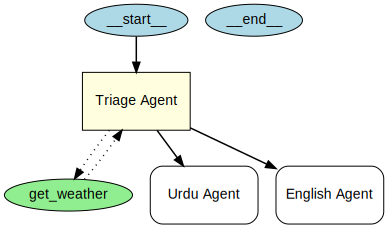

In [ ]:
from agents.extensions.visualization import draw_graph
draw_graph(triage_agent)
# draw_graph(urdu_agent)


###Agents as Tools

Handing off to Urdu Agent Agent
Urdu Agent
محبت ایک گہرا احساس ہے جو کسی کے لیے دلی لگاؤ اور احترام کو ظاہر کرتا ہے۔



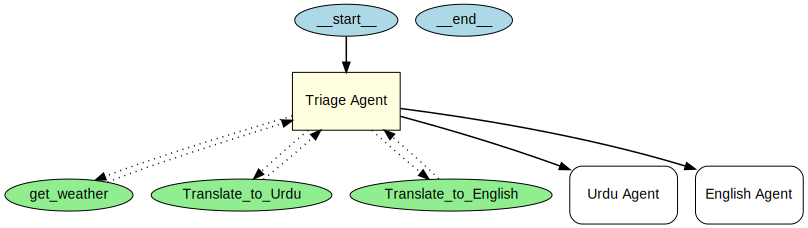

In [ ]:
from agents import handoff,RunContextWrapper,function_tool
urdu_agent=Agent(
    name="Urdu Agent",
    instructions="You only answer questions in Urdu",
    model=get_model("gemini"),
    handoff_description="Urdu Expert"
)

english_agent=Agent(
    name="English Agent",
    instructions="You only answer questions in English.",
    model=get_model("gemini"),
    handoff_description="English Expert"
)

def on_agent_handoff(agent:Agent,ctx:RunContextWrapper):
    print(f"Handing off to {agent.name} Agent")
    # print(f"ctx: {ctx}")
    # print(f"Agent: {agent.name}")

@function_tool
def get_weather(city:str)->str:
    print(f"Getting weather for {city}")
    return f"The weather in {city} is sunny"

# get_weather=function_tool(get_weather
triage_agent=Agent(
    name="Triage Agent",
    instructions="Handoff to the appropriate agent based on the language of the request.",
    model=get_model("groq"),
    tools=[
        get_weather,
        urdu_agent.as_tool(tool_name="Translate_to_Urdu",tool_description="Translate the user's message to Spanish."),
        english_agent.as_tool(tool_name="Translate_to_English",tool_description="Translate the user's message to English.")
        ],
    handoffs=[
        handoff(agent=urdu_agent,on_handoff=lambda ctx: on_agent_handoff(urdu_agent,ctx)),
        handoff(agent=english_agent,on_handoff=lambda ctx: on_agent_handoff(english_agent,ctx))
    ]
)

result=Runner.run_sync(
    starting_agent=triage_agent,
    input="What is love.short answer in urdu.?"
)
print(result.last_agent.name)
print(result.final_output)

draw_graph(triage_agent)
# draw_graph(urdu_agent)

###Agent Local Context

context: RunContextWrapper(context=UserInfo(name='Muhammad Ahtisham', email='iamahtishamyousaf@gmail.com', age=22, gender='male', role='AI/ML Engineer', uid=123), usage=Usage(requests=1, input_tokens=58, output_tokens=9, total_tokens=67))
context.context_wrapper: Muhammad Ahtisham
Hello Muhammad Ahtisham,Welcome to Panaversity!



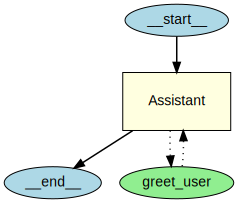

In [ ]:
from dataclasses import dataclass
from agents.extensions.visualization import draw_graph

@dataclass
class UserInfo:
    name:str
    email:str
    age:int
    gender:str
    role:str
    uid:int


@function_tool
def greet_user(context:RunContextWrapper[UserInfo],greeting:str) ->str:
    """
    Greets the user with the given greeting.

    Args:
    greeting: A string representing the greeting to be used.

    Returns:
    A string representing the greeting message.
    """
    print(f"context: {context}")
    print(f"context.context_wrapper: {context.context.name}")
    return f"Hello {context.context.name},{greeting}"


user_info=UserInfo(name="Muhammad Ahtisham",email="iamahtishamyousaf@gmail.com",age=22,gender="male",role="AI/ML Engineer",uid=123)

greet_agent=Agent[UserInfo](
    name="Assistant",
    instructions="Always greet the user using greet_user and welcome them to Panaversity",
    tools=[greet_user],
    model=get_model("gemini")
)
result=Runner.run_sync(
    starting_agent=greet_agent,
    input="Hi?",
    context=user_info
)
print(result.final_output)
draw_graph(greet_agent)




###Streaming

In [ ]:
from openai.types.responses import ResponseTextDeltaEvent
from time import sleep
agent=Agent(
    name="Assistant",
    instructions="You are a helpful assistant",
    model=get_model("gemini")
)

result=Runner.run_streamed(
    starting_agent=agent,
    input="What is love?"
)

async for chunk in result.stream_events():
    if chunk.type=='raw_response_event'and isinstance(chunk.data,ResponseTextDeltaEvent):
        print(chunk.data.delta,end="",flush=True)
        sleep(2)
    # print(chunk)

Ah, love! That's a question that has occupied philosophers, poets, artists, and pretty much everyone else since the dawn of time. There's no single, universally accepted definition, as it's a complex and multifaceted experience. Here's a breakdown of some common perspectives:

**From a Biological/Scientific Standpoint:**

*   **Evolutionary Drive:** Love, at its core, is seen as a biological drive to reproduce and ensure the survival of the species. Attraction, bonding, and commitment are all mechanisms that encourage pair-bonding and raising offspring.
*   **Hormones & Neurotransmitters:** Chemicals like dopamine, serotonin, oxytocin, and vasopressin play significant roles in the feelings associated with love, such as pleasure, attachment, and trust.

**From a Psychological Standpoint:**

*   **Attachment:** Attachment theory describes love as a deep emotional bond that connects one person to another, providing a sense of security and comfort.
*   **Sternberg's Triangular Theory:** Th

In [ ]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
import asyncio
from openai.types.responses import ResponseTextDeltaEvent #Especially use for text streaming
async def main():
    agent=Agent(name='Researcher',instructions="You're a helpful assistant for AI Agents")
    # question="why we should build custom agents while n8n is doing everything?"
    question="what is the capital of pakistan and it's qualities."
    response= Runner.run_streamed(agent,question,run_config=configuration)
    async for chunk in response.stream_events():
        if chunk.type=='raw_response_event'and isinstance(chunk.data,ResponseTextDeltaEvent):
            print(chunk.data.delta,end="",flush=True)
            # print("=============================")
            # print()
        # print(chunk)
    # print(response)

asyncio.run(main())


NameError: name 'configuration' is not defined

###Structured output

In [ ]:
import asyncio
from pydantic import BaseModel
from agents import Agent, Runner

# Define a structured output model using Pydantic
class CapitalInfo(BaseModel):
    country: str
    capital: str
    population: int
    fun_fact: str

# Create an agent with structured output
structured_agent = Agent(
    name="capital_info_agent",
    instructions="You are a helpful assistant that provides information about capital cities. Return structured data with the country, capital name, approximate population, and one fun fact.",
    output_type=CapitalInfo,
    model=model
)

# Create a coroutine to run the agent
coro = Runner.run_sync(
    structured_agent,
    [{"role": "user", "content": "What's the capital of France?"}]
)

print(coro.final_output)

country='France' capital='Paris' population=2141000 fun_fact="The Eiffel Tower was originally meant to be a temporary structure for the 1889 World's Fair."


###Guardrails

In [ ]:
!pip install -Uq openai_agents pydantic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.3 MB/s eta 0:00:00


In [ ]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
from agents import (
    AsyncOpenAI,
    OpenAIChatCompletionsModel,
    RunConfig,
    Agent,
    Runner,
    set_default_openai_client,
    set_tracing_disabled,
    function_tool,
    Tool,
    RunHooks,
    RunContextWrapper,
    Usage,

)
from google.colab import userdata
from pydantic import BaseModel,Field
GEMINI_API_KEY=userdata.get("GEMINI_API_KEY")

set_tracing_disabled(disabled=True)

model=OpenAIChatCompletionsModel(
    model="gemini-2.0-flash",
    openai_client=AsyncOpenAI(
        api_key=GEMINI_API_KEY,
        base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
    )
)

class MathHomeWorkOutput(BaseModel):
    is_math_homework:bool
    why:str


input_guardrail_agent=Agent(
    name="Guardrail Check Agent",
    instructions="Check if the user is asking you to do thier math homework.",
    output_type=MathHomeWorkOutput,
    model=model
)

output=Runner.run_sync(
    starting_agent=input_guardrail_agent,
    input="What is 2+2?"
)
print(output.final_output)
print(output.final_output.is_math_homework)
print(output.final_output.why)


is_math_homework=True why='The user is asking a basic arithmetic question, which is commonly found in math homework for young students.'
True
The user is asking a basic arithmetic question, which is commonly found in math homework for young students.


In [ ]:
from agents import input_guardrail,GuardrailFunctionOutput,InputGuardrailTripwireTriggered

@input_guardrail
async def math_guardrail(ctx: RunContextWrapper, agent:Agent, input: str |list[str]) -> GuardrailFunctionOutput:
    result = await Runner.run(
        starting_agent=input_guardrail_agent,
        input=input,
        # context=ctx.context
    )

    return GuardrailFunctionOutput(
        output_info=result.final_output,
        tripwire_triggered=result.final_output.is_math_homework
    )

main_agent=Agent(
    name="English Agent",
    instructions="You only answer questions in English.",
    model=model,
    input_guardrails=[math_guardrail]
)

try:
    result=Runner.run_sync(
        starting_agent=main_agent,
        # input="What is 2+2?"
        input="what is the base of english"
    )
    print("Safe Input")
    print(result.final_output)
except InputGuardrailTripwireTriggered:
    print("Input guardrail triggered")


Safe Input
The base of English is complex and multifaceted, drawing from a variety of sources. Here's a breakdown of the major influences:

*   **Proto-Indo-European (PIE):** This is the reconstructed ancestor of a vast family of languages, including English, Greek, Latin, Sanskrit, and many others. While we don't have direct records of PIE, linguists have reconstructed it by comparing similarities across its descendant languages. English inherits very basic vocabulary and grammatical structures from PIE.

*   **Proto-Germanic:** As PIE evolved and migrated, it branched into various families, including Germanic. English belongs to the West Germanic branch. Proto-Germanic is the source of many core English words and grammatical features that set it apart from Romance languages like French or Spanish.

*   **Old English (Anglo-Saxon):** This is the earliest form of English, spoken in England from the 5th to the 11th centuries AD. It was brought to Britain by Germanic tribes (Angles, Saxo

In [ ]:
class CountryOutput(BaseModel):
    is_allowed:bool
    reason:str
    country:str
    answer:str

country_guardrail_agent=Agent(
    name="Country Guardrail Agent",
    instructions="Check if the user is asking you about other countries. We only allow about paksitan",
    output_type=CountryOutput,
    model=model
)

result=Runner.run_sync(
    starting_agent=country_guardrail_agent,
    input="What is the capital of Pakistan?"
)
# print(result.final_output)
print(result.final_output.is_allowed)
print(result.final_output.reason)
print(result.final_output.country)
print(result.final_output.answer)

print("*"*20)
print(result.final_output.model_dump_json())

True
User asked about the capital of Pakistan.
Pakistan
The capital of Pakistan is Islamabad.
********************
{"is_allowed":true,"reason":"User asked about the capital of Pakistan.","country":"Pakistan","answer":"The capital of Pakistan is Islamabad."}


In [ ]:
from agents import output_guardrail,GuardrailFunctionOutput,OutputGuardrailTripwireTriggered

@output_guardrail
async def country_guardrail(ctx: RunContextWrapper, agent:Agent, output:str) -> GuardrailFunctionOutput:
    print(f"Output: {output}")
    result = await Runner.run(
        starting_agent=country_guardrail_agent,
        input=output,
        context=ctx.context
    )
    print("\n\n[Guardrail Response]", result.final_output,"\n\n")
    return GuardrailFunctionOutput(
        output_info=result.final_output,
        tripwire_triggered=result.final_output.is_allowed
    )

main_agent=Agent(
    name="English Agent",
    instructions="You only answer questions in English.",
    model=model,
    output_guardrails=[country_guardrail]
)
try:
    result=Runner.run_sync(
        starting_agent=main_agent,
        input="What is english."
    )
    print(result.final_output)

except OutputGuardrailTripwireTriggered as e:
    print("Output guardrail triggered", e)


Output: English is a West Germanic language that originated in England and is now spoken worldwide. It's the third most-spoken language in the world (by native speakers), the most widely learned language, and an official language in many countries.

Here are some key aspects of English:

*   **Origins:** It evolved from the dialects of Germanic tribes who migrated to Britain in the 5th and 6th centuries.
*   **Influence:** Over time, it has been influenced by various languages, including Latin, French, and others.
*   **Global Language:** It serves as a lingua franca in many international contexts, including business, science, technology, and diplomacy.
*   **Alphabet:** It uses the Latin alphabet, with 26 letters.
*   **Grammar:** English grammar has evolved over time and is often considered relatively flexible compared to some other languages.
*   **Vocabulary:** It has a vast vocabulary, due in part to its history of borrowing words from other languages.
*   **Dialects:** Many diffe

##PIAIC Guardrails Exemple

In [ ]:
import asyncio
from pydantic import BaseModel,Field
from agents import (
    input_guardrail, #or InputGuardrail,
    InputGuardrail,
    GuardrailFunctionOutput,
    InputGuardrailTripwireTriggered
)

#Define the output model for guardrail agent
class PIAICReleventOutput(BaseModel):
    is_piaic_relevent:bool
    reason:str

guardrail_agent=Agent(
    name="PIAIC Guardrail Agent",
        instructions=(
        "You are a guardrail agent that checks if the user's input is related to PIAIC (Presidential Initiative for Artificial Intelligence and Computing) topics, "
        "such as Artificial Intelligence, Cloud Native Computing, Blockchain, Internet of Things (IoT), or other PIAIC courses. "
        "Determine if the input is relevant to PIAIC. "
        "Return a structured output with 'is_piaic_relevant' as a boolean and 'reasoning' explaining your decision."
    ),
    output_type=PIAICReleventOutput,
    model=model
)
#DEFINE the piaic guardrail function
async def piaic_relevent_guardrail(ctx: RunContextWrapper[None],agent: Agent,input: str | list)->GuardrailFunctionOutput:
    result = await Runner.run(
        starting_agent=guardrail_agent,
        input=input,
        # context=ctx.context
    )
    # print("result",result)
    final_result=result.final_output_as(PIAICReleventOutput)
    # print(final_result)
    guardrail_function_output=GuardrailFunctionOutput(
        output_info=final_result,
        tripwire_triggered=not final_result.is_piaic_relevent
    )

    return guardrail_function_output


#Create the main PIAIC agent
piaic_agent=Agent(
    name="PIAIC Assistant",
    instructions=(
        "You are a helpful assistant for PIAIC-related questions. "
        "Answer questions about PIAIC courses, such as AI, Cloud Native Computing, Blockchain, IoT, or other PIAIC initiatives. "
        "Provide accurate and concise information."
    ),
    model=model,
    input_guardrails=[InputGuardrail(guardrail_function=piaic_relevent_guardrail)]
)

try:
    result = await Runner.run(piaic_agent, "What is the curriculum for PIAIC's AI course?")
    print("Response:", result.final_output)
except InputGuardrailTripwireTriggered as e:
    print("Guardrail tripped: Input is not PIAIC-related.")



Response: The PIAIC AI course curriculum is designed to provide a comprehensive understanding of artificial intelligence, covering both theoretical foundations and practical applications. Here's a breakdown of the key components:

*   **Fundamentals of Python Programming:** Introduces the basics of Python, the primary language used in AI development.
*   **Mathematics for AI:** Covers essential mathematical concepts like linear algebra, calculus, probability, and statistics, which are crucial for understanding AI algorithms.
*   **Machine Learning:** Delves into various machine-learning techniques, including supervised learning (regression, classification), unsupervised learning (clustering, dimensionality reduction), and reinforcement learning.
*   **Deep Learning:** Explores neural networks and deep learning architectures, such as convolutional neural networks (CNNs) for image recognition and recurrent neural networks (RNNs) for natural language processing.
*   **Natural Language Pro

In [ ]:
try:
    result = await Runner.run(piaic_agent, "What is xeven solutions?")
    print("Response:", result.final_output)
except InputGuardrailTripwireTriggered as e:
    print("Guardrail tripped: Input is not PIAIC-related.")



Guardrail tripped: Input is not PIAIC-related.


####Output and input guardrails

In [ ]:

import asyncio
from pydantic import BaseModel
from agents import (
    Agent,
    GuardrailFunctionOutput,
    InputGuardrail,
    InputGuardrailTripwireTriggered,
    OutputGuardrail,
    OutputGuardrailTripwireTriggered,
    RunContextWrapper,
    Runner,
)

# Define the output model for the guardrail agents
class PIAICRelevanceOutput(BaseModel):
    is_piaic_relevant: bool
    reasoning: str

# Create the input guardrail agent to check if input is PIAIC-related
input_guardrail_agent = Agent(
    name="PIAIC_Input_Relevance_Check",
    instructions=(
        "You are a guardrail agent that checks if the user's input is related to PIAIC (Presidential Initiative for Artificial Intelligence and Computing) topics, "
        "such as Artificial Intelligence, Cloud Native Computing, Blockchain, Internet of Things (IoT), or other PIAIC courses. "
        "Determine if the input is relevant to PIAIC. "
        "Return a structured output with 'is_piaic_relevant' as a boolean and 'reasoning' explaining your decision."
    ),
    model=model,
    output_type=PIAICRelevanceOutput,
)

# Create the output guardrail agent to check if output is PIAIC-related
output_guardrail_agent = Agent(
    name="PIAIC_Output_Relevance_Check",
    instructions=(
        "You are a guardrail agent that checks if the agent's response is related to PIAIC (Presidential Initiative for Artificial Intelligence and Computing) topics, "
        "such as Artificial Intelligence, Cloud Native Computing, Blockchain, Internet of Things (IoT), or other PIAIC courses. "
        "Determine if the response content is relevant to PIAIC. "
        "Return a structured output with 'is_piaic_relevant' as a boolean and 'reasoning' explaining your decision."
    ),
    model=model,
    output_type=PIAICRelevanceOutput,
)

# Define the input guardrail function
async def piaic_input_relevance_guardrail(
    ctx: RunContextWrapper[None],
    agent: Agent,
    input: str | list,
) -> GuardrailFunctionOutput:
    result = await Runner.run(input_guardrail_agent, input, context=ctx.context)
    final_output = result.final_output_as(PIAICRelevanceOutput)
    return GuardrailFunctionOutput(
        output_info=final_output,
        tripwire_triggered=not final_output.is_piaic_relevant,
    )

# Define the output guardrail function
async def piaic_output_relevance_guardrail(
    ctx: RunContextWrapper[None],
    agent: Agent,
    output: str | list,
) -> GuardrailFunctionOutput:
    result = await Runner.run(output_guardrail_agent, output, context=ctx.context)
    final_output = result.final_output_as(PIAICRelevanceOutput)
    return GuardrailFunctionOutput(
        output_info=final_output,
        tripwire_triggered=not final_output.is_piaic_relevant,
    )

# Create the main PIAIC agent with both input and output guardrails
piaic_agent = Agent(
    name="PIAIC_Assistant",
    instructions=(
        "You are a helpful assistant for PIAIC-related questions. "
        "Answer questions about PIAIC courses, such as AI, Cloud Native Computing, Blockchain, IoT, or other PIAIC initiatives. "
        "Provide accurate and concise information."
    ),
    model=model,
    input_guardrails=[InputGuardrail(guardrail_function=piaic_input_relevance_guardrail)],
    output_guardrails=[OutputGuardrail(guardrail_function=piaic_output_relevance_guardrail)],
)


try:
    result = await Runner.run(piaic_agent, "What is the curriculum for PIAIC's AI course?")
    print("Response:", result.final_output)
except InputGuardrailTripwireTriggered as e:
    print("Input Guardrail tripped: Input is not PIAIC-related.")



Response: The PIAIC AI course curriculum is designed to provide a comprehensive foundation in Artificial Intelligence, covering both theoretical concepts and practical applications. Here's a breakdown of the key areas:

*   **Fundamentals of Python Programming:**
    *   Introduction to Python syntax, data structures, and control flow.
    *   Object-oriented programming concepts.
    *   Essential libraries for data science and AI (NumPy, Pandas, Matplotlib, Seaborn).
*   **Mathematics for AI:**
    *   Linear Algebra: Vectors, matrices, operations, and applications in AI.
    *   Calculus: Derivatives, gradients, and optimization techniques.
    *   Probability and Statistics: Probability distributions, hypothesis testing, and statistical analysis.
*   **Machine Learning:**
    *   Supervised Learning: Regression, classification, and model evaluation.
    *   Unsupervised Learning: Clustering, dimensionality reduction, and anomaly detection.
    *   Model Selection and Evaluation: Cr

###Run Life Cycle

####Simple Example

In [ ]:
!pip install openai_agents "openai-agents[litellm,viz]"

INFO: pip is looking at multiple versions of litellm to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.5/119.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.3 MB/s eta 0:00:00


In [ ]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
from google.colab import userdata
from agents import (
    AsyncOpenAI,
    OpenAIChatCompletionsModel,
    RunConfig,
    Agent,
    Runner,
    set_default_openai_client,
    set_tracing_disabled,
    function_tool,
    Tool,
    RunHooks,
    RunContextWrapper,
    Usage
)
import asyncio, random
from typing import Any,List,cast


GEMINI_API_KEY=userdata.get("GEMINI_API_KEY")
GROQ_API_KEY=userdata.get("GROQ_API_KEY")

set_tracing_disabled(disabled=True)

model=OpenAIChatCompletionsModel(
    model="gemini-1.5-flash",
    openai_client=AsyncOpenAI(
        api_key=GEMINI_API_KEY,
        base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
    )
)


class TestHooks(RunHooks):
    def __init__(self):
        self.event_counter=0
        self.name="TestHooks"

    async def on_agent_start(self, context: RunContextWrapper, agent: Agent) -> None:
        self.event_counter+=1
        print(f"### `{self.name} {self.event_counter}`: Agent `{agent.name}` started. Usage `{context.usage}`")

    async def on_agent_end(self, context: RunContextWrapper, agent:Agent,output:Any) ->None:
        self.event_counter+=1
        print(f"### `{self.name} {self.event_counter}`: Agent `{agent.name}` ended. Usage `{context.usage}`, Output: `{output}`")


start_hook=TestHooks()

start_agent=Agent(
    name="Content Modrator Agent",
    instructions="You are a content modrator agent. Watch social media content  received and flag queries that need help or answer. We will answer anything about AI?",
    model=model
)

async def main():
    result=await Runner.run(
        starting_agent=start_agent,
        input=f"Will agentic AI Die at the end of 2025?",
        hooks=start_hook
    )

    print(result.final_output)
    print("--End--")

asyncio.run(main())

### `TestHooks 1`: Agent `Content Modrator Agent` started. Usage `Usage(requests=0, input_tokens=0, output_tokens=0, total_tokens=0)`
### `TestHooks 2`: Agent `Content Modrator Agent` ended. Usage `Usage(requests=1, input_tokens=45, output_tokens=67, total_tokens=112)`, Output: `This query needs help.  It's a question about a specific prediction regarding AI ("agentic AI") that requires clarification and fact-checking.  There's no established definition of "agentic AI" with a commonly accepted lifespan prediction tied to it.  The claim needs further investigation to determine its validity and source.
`
This query needs help.  It's a question about a specific prediction regarding AI ("agentic AI") that requires clarification and fact-checking.  There's no established definition of "agentic AI" with a commonly accepted lifespan prediction tied to it.  The claim needs further investigation to determine its validity and source.

--End--


####Advanced Example (With Tools and Agents Handoffs)

In [ ]:
from agents.run_context import TContext

class ExampleHooks(RunHooks):
    def __init__(self):
        self.event_counter=0

    def _usage_to_str(self,usage:Usage) ->str:
        print("### _usage_to_str function is calling..")
        return (f"usage: {usage}")
        # return f"Request: {usage.requests}, Input_tokens: {usage.input_tokens}, Output tokens: {usage.output_tokens}, Total Tokens: {usage.total_tokens}"

    async def on_agent_start(self, context_wrapper: RunContextWrapper, agent: Agent):
        self.event_counter+=1
        print("*"*30)
        print("### On Agent start")
        print(f"ContextWrapper: {context_wrapper}")
        print(f"Agent: {agent}")
        # print(f"Event counter: {self.event_counter}: Agent `{agent.name}` started. Usage: {self._usage_to_str(context.usage)}")

    async def on_agent_end(self, context: RunContextWrapper[TContext], agent: Agent[TContext], output: Any) -> None:
        self.event_counter+=1
        print("*"*30)
        print("### On Agent end")
        print(f"ContextWrapper: {context}")
        print(f"Agent: {agent}")
        print(f"Output: {output}")
    async def on_tool_start(self, context: RunContextWrapper, tool: Tool, input: Any):
        self.event_counter+=1
        print("*"*30)
        print("### On Tool start")
        print(f"ContextWrapper: {context}")
        print(f"Tool: {tool}")
        print(f"Input: {input}")
    async def on_tool_end(self, context: RunContextWrapper, tool: Tool, output: Any,result:str):
        self.event_counter+=1
        print("*"*30)
        print("### On Tool End")
        print(f"ContextWrapper: {context}")
        print(f"Tool: {tool}")
        print(f"Output: {output}")
        print(f"Result: {result}")
    async def on_handoff(self, context: RunContextWrapper, from_agent: Agent, to_agent:Agent):
        self.event_counter+=1
        print("*"*30)
        print("### On Handoff")
        print(f"ContextWrapper: {context}")
        print(f"From Agent: {from_agent}")
        print(f"To Agent: {to_agent}")


hooks=ExampleHooks()

@function_tool("random_number")
def random_number(max:int) ->int:
    """This function generates random num up to provided max."""
    print(f"Agent is calling random number tool with given num: {max}")
    generated_num=random.randint(0,max)
    print(f"Generated num: {generated_num}")
    return generated_num


@function_tool("multiply_by_two")
def multiply_by_two(number:int) ->int:
    """This function multiplies provided number by 2."""
    print(f"Agent is calling multiply by 2 tool with num: {number}")
    multiplied_num= number*2
    print(f"Multiplied num: {number*2}")
    return multiplied_num

# multiply_agent=Agent(
#     name="Multiply Agent",
#     instructions="Multiply the number by 2 and return the final result",
#     # tools=[multiply_by_two],
#     model=model
# )

start_agent=Agent(
    name="Start Agent",
    instructions="Generate a random number between given number and multiply it by 2 and also give generated number.",
    tools=[random_number,multiply_by_two],
    model=model,
    # handoffs=[multiply_agent]
)

async def main():
    user_input=input("Enter a number: ")
    result=await Runner.run(
        starting_agent=start_agent,
        input=user_input,
        hooks=hooks
    )
    # print(result.final_output)
    print("--End--")

asyncio.run(main())

Enter a number: 2
******************************
### On Agent start
ContextWrapper: RunContextWrapper(context=None, usage=Usage(requests=0, input_tokens=0, output_tokens=0, total_tokens=0))
Agent: Agent(name='Start Agent', instructions='Generate a random number between given number and multiply it by 2 and also give generated number.', handoff_description=None, handoffs=[], model=<agents.models.openai_chatcompletions.OpenAIChatCompletionsModel object at 0x7daaccc95450>, model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=None, truncation=None, max_tokens=None, reasoning=None, metadata=None, store=None, include_usage=None, extra_query=None, extra_body=None, extra_headers=None), tools=[FunctionTool(name='random_number', description='This function generates random num up to provided max.', params_json_schema={'properties': {'max': {'title': 'Max', 'type': 'integer'}}, 'required': ['max'], 'title': 

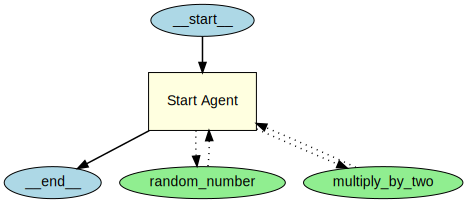

In [ ]:
from agents.extensions.visualization import draw_graph
draw_graph(start_agent)

####Agent Hook life Cycle

In [ ]:
from agents import AgentHooks

class CustomAgentHooks(AgentHooks):
    def __init__(self, display_name: str):
        self.event_counter = 0
        self.display_name = display_name
    #on_agent_start for RunHook
    async def on_start(self, context: RunContextWrapper, agent: Agent) -> None:
        self.event_counter += 1
        print(f"### ({self.display_name}) {self.event_counter}: Agent {agent.name} started")
    #on_agent_end for RunHook
    async def on_end(self, context: RunContextWrapper, agent: Agent, output: Any) -> None:
        self.event_counter += 1
        print(
            f"### ({self.display_name}) {self.event_counter}: Agent {agent.name} ended with output {output}"
        )

    async def on_handoff(self, context: RunContextWrapper, agent: Agent, source: Agent) -> None:
        self.event_counter += 1
        print(
            f"### ({self.display_name}) {self.event_counter}: Agent {source.name} handed off to {agent.name}"
        )

    async def on_tool_start(self, context: RunContextWrapper, agent: Agent, tool: Tool) -> None:
        self.event_counter += 1
        print(
            f"### ({self.display_name}) {self.event_counter}: Agent {agent.name} started tool {tool.name}"
        )

    async def on_tool_end(
        self, context: RunContextWrapper, agent: Agent, tool: Tool, result: str
    ) -> None:
        self.event_counter += 1
        print(
            f"### ({self.display_name}) {self.event_counter}: Agent {agent.name} ended tool {tool.name} with result {result}"
        )

In [ ]:
from pydantic import BaseModel
@function_tool
def random_number(max: int) -> int:
    """
    Generate a random number up to the provided maximum.
    """
    return random.randint(0, max)


@function_tool
def multiply_by_two(x: int) -> int:
    """Simple multiplication by two."""
    return x * 2


class FinalResult(BaseModel):
    number: int


multiply_agent = Agent(
    name="Multiply Agent",
    instructions="Multiply the number by 2 and then return the final result.",
    tools=[multiply_by_two],
    hooks=CustomAgentHooks(display_name="MultiplyAgent"),
    model=model
)

start_agent = Agent(
    name="Start Agent",
    instructions="Generate a random number. If it's even, stop. If it's odd, hand off to the multiply agent.",
    tools=[random_number],
    handoffs=[multiply_agent],
    hooks=CustomAgentHooks(display_name="StartAgent"),
    model=model # Optional: defaults to "gpt-4o" if not specified

)


async def main() -> None:
    user_input = input("Enter a max number: ")
    await Runner.run(
        start_agent,
        input=f"Generate a random number between 0 and {user_input}.",
    )

    print("Done!")


asyncio.run(main())


Enter a max number: 2
### (StartAgent) 1: Agent Start Agent started
### (StartAgent) 2: Agent Start Agent started tool random_number
### (StartAgent) 3: Agent Start Agent ended tool random_number with result 0
### (StartAgent) 4: Agent Start Agent ended with output The random number generated is 0.  Since 0 is even, the process stops here.

Done!


#Data Camp Article

##ModelSettings

@dataclass
class ModelSettings:
    """Settings to use when calling an LLM.

    This class holds optional model configuration parameters (e.g. temperature,
    top_p, penalties, truncation, etc.).

    Not all models/providers support all of these parameters, so please check the API documentation
    for the specific model and provider you are using.
    """

    temperature: float | None = None
    """The temperature to use when calling the model."""

    top_p: float | None = None
    """The top_p to use when calling the model."""

    frequency_penalty: float | None = None
    """The frequency penalty to use when calling the model."""

    presence_penalty: float | None = None
    """The presence penalty to use when calling the model."""

    tool_choice: Literal["auto", "required", "none"] | str | None = None
    """The tool choice to use when calling the model."""

    parallel_tool_calls: bool | None = None
    """Whether to use parallel tool calls when calling the model.
    Defaults to False if not provided."""

    truncation: Literal["auto", "disabled"] | None = None
    """The truncation strategy to use when calling the model."""

    max_tokens: int | None = None
    """The maximum number of output tokens to generate."""

    reasoning: Reasoning | None = None
    """Configuration options for
    [reasoning models](https://platform.openai.com/docs/guides/reasoning).
    """

    metadata: dict[str, str] | None = None
    """Metadata to include with the model response call."""

    store: bool | None = None
    """Whether to store the generated model response for later retrieval.
    Defaults to True if not provided."""

    include_usage: bool | None = None
    """Whether to include usage chunk.
    Defaults to True if not provided."""

    extra_query: Query | None = None
    """Additional query fields to provide with the request.
    Defaults to None if not provided."""

    extra_body: Body | None = None
    """Additional body fields to provide with the request.
    Defaults to None if not provided."""

    extra_headers: Headers | None = None
    """Additional headers to provide with the request.
    Defaults to None if not provided."""

    def resolve(self, override: ModelSettings | None) -> ModelSettings:
        """Produce a new ModelSettings by overlaying any non-None values from the
        override on top of this instance."""
        if override is None:
            return self

        changes = {
            field.name: getattr(override, field.name)
            for field in fields(self)
            if getattr(override, field.name) is not None
        }
        return replace(self, **changes)

    def to_json_dict(self) -> dict[str, Any]:
        dataclass_dict = dataclasses.asdict(self)

        json_dict: dict[str, Any] = {}

        for field_name, value in dataclass_dict.items():
            if isinstance(value, BaseModel):
                json_dict[field_name] = value.model_dump(mode="json")
            else:
                json_dict[field_name] = value

        return json_dict

In [ ]:
from agents import ModelSettings

advanced_agent=Agent(
    name="Advanced Agent",
    instructions="""You are a professional, concise assistant who always provides
    accurate information. When you don't know something, clearly state that gently.
    Focus on giving actionale insights when answring something.""",
    model=model,
    model_settings=ModelSettings( #This is a @dataclass
        temperature=0.3, #Lower for more deterministic outputs (0.0-2.0)
        max_tokens=1024, #Maximun length of response
        # more parameters and values
    )

)

##Hosted Tools (only work with openai api key)

In [ ]:
from agents import WebSearchTool,FileSearchTool,ComputerTool

location_aware_search=WebSearchTool(
    user_location="Lahore, Pakistan",
    # search_context_size=
)

##Weather Assistant (WeatherWise)

In [ ]:

# Define detailed instructions for our weather assistant
weather_instructions = """
You are a weather information assistant who helps users understand weather patterns and phenomena.

YOUR EXPERTISE:
- Explaining weather concepts and terminology
- Describing how different weather systems work
- Answering questions about climate and seasonal patterns
- Explaining the science behind weather events

LIMITATIONS:
- You cannot provide real-time weather forecasts for specific locations
- You don't have access to current weather data
- You should not make predictions about future weather events

STYLE:
- Use clear, accessible language that non-meteorologists can understand
- Include interesting weather facts when relevant
- Be enthusiastic about meteorology and climate science
"""

# Create our specialized weather assistant
weather_assistant = Agent(
   name="WeatherWise",
   instructions=weather_instructions,
   model=model,
   model_settings=ModelSettings(
       temperature=0.5,  # Balanced temperature for natural but focused responses
       max_tokens=256,  # Maximum length of response
   )
)

In [ ]:
from dataclasses import dataclass
from pydantic import BaseModel, Field
from typing import Optional, List

@dataclass
class WeatherInfo:
    temperature:float
    feels_like:float
    humidity: int
    description:str
    wind_speed: float
    pressure:int
    location_name:str
    rain_1h:Optional[float]=None
    visibility: Optional[int]=None


@function_tool
def get_weather_info(location:str) -> WeatherInfo:
    """Get the current weather information for a given location."""
    print(f"Calling Weather Info Tool for {location}")
    try:
        weather_info = WeatherInfo(
            temperature=25.5,
            feels_like=27.0,
            humidity=70,
            description="Partly cloudy",
            wind_speed=10.0,
            pressure=1012,
            location_name=location,
            rain_1h=0.0,
            visibility=10000
        )

     # Build the response string
        weather_report = f"""
        Weather in {weather_info.location_name}:
        - Temperature: {weather_info.temperature}°C (feels like {weather_info.feels_like}°C)
        - Conditions: {weather_info.description}
        - Humidity: {weather_info.humidity}%
        - Wind speed: {weather_info.wind_speed} m/s
        - Pressure: {weather_info.pressure} hPa
        """
        return weather_report

    except Exception as e:
        return f"Error: {e}"

weather_agent=Agent(
    name="Weather Agent",
    instructions="""You are a weather assistant that can provide current weather information.

    When asked about weather, use the get_weather_info tool to fetch accurate data.
    If the user doesn't specify a country code and there might be ambiguity,
    ask for clarification (e.g., Paris, France vs. Paris, Texas).

    Provide friendly commentary along with the weather data, such as clothing suggestions
    or activity recommendations based on the conditions.
    """,
    model=model,
    # output_type=WeatherInfo,
    model_settings=ModelSettings(
        temperature=0.5,  # Balanced temperature for natural but focused responses
        max_tokens=256,  # Maximum length of response/tokens
    ),
    tools=[get_weather_info]
)
user_input=input("Enter a location: ")
result=Runner.run_sync(
    starting_agent=weather_agent,
    input=user_input

)

print(f"Full Result: {result}")

Enter a location: what are your capabilities
Full Result: RunResult:
- Last agent: Agent(name="Weather Agent", ...)
- Final output (str):
    I am a weather assistant. I can provide you with current weather information for a given location.  I will do my best to give you friendly commentary and suggestions based on the weather conditions.
- 1 new item(s)
- 1 raw response(s)
- 0 input guardrail result(s)
- 0 output guardrail result(s)
(See `RunResult` for more details)


In [ ]:
user_input=input("Enter a location: ")
result=Runner.run_sync(
    starting_agent=weather_agent,
    input=user_input
)
print(f"Full Result: {result}")

Enter a location: what is the weather in lahore,pakistan
Calling Weather Info Tool for lahore,pakistan
Full Result: RunResult:
- Last agent: Agent(name="Weather Agent", ...)
- Final output (str):
    The weather in Lahore, Pakistan is partly cloudy with a temperature of 25.5°C, but it feels like 27°C due to the humidity.  The wind is blowing at 10.0 m/s.  It might be a good day for a light jacket, and perhaps some sightseeing!
- 3 new item(s)
- 2 raw response(s)
- 0 input guardrail result(s)
- 0 output guardrail result(s)
(See `RunResult` for more details)


##Structured output

In [ ]:
pip install litellm

In [ ]:
# classes
from pydantic import BaseModel,Field
from typing import List, Optional
from agents import ModelSettings
from dataclasses import dataclass

GEMINI_API_KEY=userdata.get("GEMINI_API_KEY")
GROQ_API_KEY=userdata.get("GROQ_API_KEY")

set_tracing_disabled(disabled=True)



#Reference: https://ai.google.dev/gemini-api/docs/openai
external_client = AsyncOpenAI(
    api_key=GEMINI_API_KEY,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/",
)

model = OpenAIChatCompletionsModel(
    model="gemini-2.0-flash",
    openai_client=external_client
)

config = RunConfig(
    model=model,
    model_provider=external_client,
    tracing_disabled=True
)

# using groq
external_client = AsyncOpenAI(
    api_key=GROQ_API_KEY,
    base_url="https://api.groq.com/openai/v1"
)

model = OpenAIChatCompletionsModel(
    model="compound-beta-mini",
    openai_client=external_client
)

class Person(BaseModel):
    name:str
    role:Optional[str]
    contact: Optional[str]

class Meeting(BaseModel):
    date:str
    time:str
    location: Optional[str]
    duration:Optional[str]

# Define task data model
class Task(BaseModel):
   description: str
   assignee: Optional[str]
   deadline: Optional[str]
   priority: Optional[str]

# Define the complete email data model
@dataclass
class EmailData:
   subject: str
   sender: str
   recipients: List[str]
   main_points: List[str]
   meetings: List[str]
   tasks: List[str]
   next_steps: Optional[str]

# Create an email extraction agent with structured output
email_extractor = Agent(
   name="Email Extractor",
   instructions="""You are an assistant that extracts structured information from emails.

   When given an email, carefully identify:
   - Subject and main points
   - People mentioned (names, roles, contact info)
   - Meetings (dates, times, locations)
   - Tasks or action items (with assignees and deadlines)
   - Next steps or follow-ups

   Extract this information as structured data. If something is unclear or not mentioned,
   leave those fields empty rather than making assumptions.
   """,
   model=model,
   output_type=EmailData,  # This tells the agent to return data in EmailData format
)

#Static email

sample_email = """
From: Alex Johnson <alex.j@techcorp.com>
To: Team Development <team-dev@techcorp.com>
CC: Sarah Wong <sarah.w@techcorp.com>, Miguel Fernandez <miguel.f@techcorp.com>
Subject: Project Phoenix Update and Next Steps

Hi team,

I wanted to follow up on yesterday's discussion about Project Phoenix and outline our next steps.

Key points from our discussion:
- The beta testing phase has shown promising results with 85% positive feedback
- We're still facing some performance issues on mobile devices
- The client has requested additional features for the dashboard

Let's schedule a follow-up meeting this Friday, June 15th at 2:00 PM in Conference Room B. The meeting should last about 1.5 hours, and we'll need to prepare the updated project timeline.

Action items:
1. Sarah to address the mobile performance issues by June 20th (High priority)
2. Miguel to create mock-ups for the new dashboard features by next Monday
3. Everyone to review the beta testing feedback document and add comments by EOD tomorrow

If you have any questions before Friday's meeting, feel free to reach out.

Best regards,
Alex Johnson
Senior Project Manager
(555) 123-4567
"""


result=Runner.run_sync(
    starting_agent=email_extractor,
    input=sample_email,
    # run_config=config
)

#the result is already a structured EmailData Ojbect because of output_type
print(f"Full Result: {result}")
# Display the extracted information
print(result.final_output)



BadRequestError: Error code: 400 - {'error': {'message': 'This model does not support response format `json_schema`', 'type': 'invalid_request_error'}}

In [ ]:
!pip install -qU openai-agents


In [ ]:
import asyncio
import datetime
from pydantic import BaseModel
from typing_extensions import TypedDict
from agents import Agent, Runner, function_tool, FunctionTool, RunContextWrapper
from google.colab import userdata
from agents import (
    AsyncOpenAI,
    OpenAIChatCompletionsModel,
    RunConfig,
    set_tracing_disabled,
    ModelSettings,
    set_default_openai_client,
    set_default_openai_key,
    set_default_openai_api,

)

# Set tracing disabled for cleaner output in this example
set_tracing_disabled(disabled=True)

# Define a structured output model for time
class TimeInfo(BaseModel):
    Hours: int
    Minutes: int

@function_tool
def get_system_time():
    """Get the current system time.

    Returns:
        A dictionary containing the current hours and minutes.
    """
    # now = datetime.datetime.now()
    return {"hours": 20, "minutes": 15}

# --- Start of Setup for Gemini via OpenAI interface ---
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")

provider = AsyncOpenAI(
    api_key=GEMINI_API_KEY,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

chat_completion_model = OpenAIChatCompletionsModel(
    model="gemini-2.0-flash-lite",
    openai_client=provider
)


# Configure RunConfig with the model and provider
# Add model_settings to address the Gemini API requirement for tool_config
run_config = RunConfig(
    model=chat_completion_model,
    model_provider=provider,
    tracing_disabled=True,
    model_settings=ModelSettings(
       tool_choice="required",
    #    tool_config=True
    )

)
# --- End of Setup ---


# Create an agent with structured output for time
time_agent = Agent(
    name="time_agent",
    instructions="""You are an agent that returns the current time in my machine.
    Use the get_system_time tool to fetch the actual system time.
    """,
    tools=[get_system_time],
    model=chat_completion_model, # Explicitly set the model
    output_type=TimeInfo,
    # Use the configured model
)

# Create a coroutine to run the agent
# Pass the configured run_config to the run_sync method
coro = Runner.run_sync(
    time_agent,
    "What time is it now?",
    run_config=run_config

)

print(coro.final_output)



BadRequestError: Error code: 400 - [{'error': {'code': 400, 'message': "For controlled generation of only function calls (forced function calling), please set 'tool_config.function_calling_config.mode' field to ANY instead of populating 'response_mime_type' and 'response_schema' fields. For more details, see: https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/function-calling#tool-config", 'status': 'INVALID_ARGUMENT'}}]

In [ ]:
!pip install litellm

In [ ]:
from litellm import completion

response=completion(
    api_key=GEMINI_API_KEY,
    model="gemini-2.0-flash-lite",
    messages=[
        {"role":"user","content":"What time is it now?"}
    ]
)

print(response)

17:03:30 - LiteLLM:ERROR: vertex_llm_base.py:290 - Failed to load vertex credentials. Check to see if credentials containing partial/invalid information.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/google/auth/compute_engine/credentials.py", line 126, in refresh
    self._retrieve_info(request)
  File "/usr/local/lib/python3.11/dist-packages/google/auth/compute_engine/credentials.py", line 99, in _retrieve_info
    info = _metadata.get_service_account_info(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/google/auth/compute_engine/_metadata.py", line 338, in get_service_account_info
    return get(request, path, params={"recursive": "true"})
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/google/auth/compute_engine/_metadata.py", line 263, in get
    raise exceptions.TransportError(
google.auth.exceptions.TransportError: ("Failed to retrieve 


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.



APIConnectionError: litellm.APIConnectionError: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Google Compute Engine metadata service. Status: 404 Response:\nb''", <google.auth.transport.requests._Response object at 0x7fc4dbcfe690>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/google/auth/compute_engine/credentials.py", line 126, in refresh
    self._retrieve_info(request)
  File "/usr/local/lib/python3.11/dist-packages/google/auth/compute_engine/credentials.py", line 99, in _retrieve_info
    info = _metadata.get_service_account_info(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/google/auth/compute_engine/_metadata.py", line 338, in get_service_account_info
    return get(request, path, params={"recursive": "true"})
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/google/auth/compute_engine/_metadata.py", line 263, in get
    raise exceptions.TransportError(
google.auth.exceptions.TransportError: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Google Compute Engine metadata service. Status: 404 Response:\nb''", <google.auth.transport.requests._Response object at 0x7fc4dbcfe690>)

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/litellm/main.py", line 2493, in completion
    model_response = vertex_chat_completion.completion(  # type: ignore
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/litellm/llms/vertex_ai/gemini/vertex_and_google_ai_studio_gemini.py", line 1410, in completion
    _auth_header, vertex_project = self._ensure_access_token(
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/litellm/llms/vertex_ai/vertex_llm_base.py", line 135, in _ensure_access_token
    return self.get_access_token(
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/litellm/llms/vertex_ai/vertex_llm_base.py", line 293, in get_access_token
    raise e
  File "/usr/local/lib/python3.11/dist-packages/litellm/llms/vertex_ai/vertex_llm_base.py", line 286, in get_access_token
    _credentials, credential_project_id = self.load_auth(
                                          ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/litellm/llms/vertex_ai/vertex_llm_base.py", line 102, in load_auth
    creds.refresh(Request())  # type: ignore
    ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/google/auth/compute_engine/credentials.py", line 132, in refresh
    raise new_exc from caught_exc
google.auth.exceptions.RefreshError: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Google Compute Engine metadata service. Status: 404 Response:\nb''", <google.auth.transport.requests._Response object at 0x7fc4dbcfe690>)


#Fitness Project-01

##Simple Agent

In [ ]:
from pydantic import BaseModel,Field

#--Structure Output Model---
class WorkoutPlan(BaseModel):
    """Workout recomendation with exercises and details"""
    focus_area:str = Field(description="Primary focus of the workout (e.g.,'upper body','cardio')")
    difficulty:str = Field(description="Difficulty level (Begginner,Intermediate,Advance)")
    exercises:list[str] = Field(description="List of recomended exercises")
    duration:int = Field(description="Duration of the workout in minutes")
    notes:str = Field(description="Additional notes or tips for the workout")

#Simple Fitness AGENT
fitness_agent=Agent(
    name="Basic Fitness Coach",
    instructions="""
    You are a fitness coach who creates workout plans for users based on their goals.

    When a user asks for workout recommendations:
    1. Determine their fitness goal (weight loss, muscle gain, endurance, etc.)
    2. Consider any information they provide about their fitness level
    3. Create an appropriate workout plan with exercises that match their goal
    4. Include form tips and safety notes

    Your responses should be practical, safe, and tailored to the user's needs.
    """,
    model=get_model("gemini"),
    output_type=WorkoutPlan #This enforces the structured output
)

query="I want to build some muscle in my upper body. I'm a beginner and don't have much equipment."
results=Runner.run_sync(
    starting_agent=fitness_agent,
    input=query

)
print("\n" + "*"*50)
print(f"QUERY: {query}")
print("\n" + "*"*50)

print("\nSTRUCTURED RESPONSE:")
print(results.final_output)

print("\n" + "#"*50)

# # print notes from the final_output
print("\nFucus Area:")
print(results.final_output.focus_area)
print("\n" + "#"*50)

# # print difficulty level from the final_output
print("\nDifficulty Level:")
print(results.final_output.difficulty)
print("\n" + "#"*50)

# # print excercises from the final_output
print("\nExercises:")
print(results.final_output.exercises)
print(len(results.final_output.exercises ))
print("\n" + "#"*50)

# # print Notes from the final_output
print("\nNOTES:")
print(results.final_output.notes)

# # print Duration from the final_output
print("\nDuration of the Exercise:")
print(results.final_output.duration)



**************************************************
QUERY: I want to build some muscle in my upper body. I'm a beginner and don't have much equipment.

**************************************************

STRUCTURED RESPONSE:
focus_area='Upper Body' difficulty='Beginner' exercises=['Push-ups (start on knees if needed): 3 sets of 8-12 reps. Keep your body in a straight line and lower yourself until your chest nearly touches the ground.', 'Dumbbell Rows (using water bottles or light dumbbells): 3 sets of 10-12 reps per arm. Hinge at your hips, keeping your back straight, and pull the weight towards your chest.', 'Overhead Press (using water bottles or light dumbbells): 3 sets of 8-12 reps. Stand with your feet shoulder-width apart and press the weight overhead, fully extending your arms.', 'Bicep Curls (using water bottles or light dumbbells): 3 sets of 10-12 reps. Keep your elbows close to your body and curl the weight towards your shoulders.', 'Triceps Dips (using a chair or bench): 3 s

##Intermediate with tools

In [ ]:
import json

#---Tools---
@function_tool
def get_exercise_info(muscle_group:str) ->str:
    print(f"Calling Exercise Info Tool for {muscle_group}")
    """Get a list of exercises for a specific muscle group"""
    exercise_data = {
        "chest": [
            "Push-ups: 3 sets of 10-15 reps",
            "Bench Press: 3 sets of 8-12 reps",
            "Chest Flyes: 4 sets of 12-15 reps",
            "Incline Push-ups: 3 sets of 10-15 reps"
        ],
        "back": [
            "Pull-ups: 3 sets of 6-10 reps",
            "Bent-over Rows: 3 sets of 8-12 reps",
            "Lat Pulldowns: 3 sets of 10-12 reps",
            "Superman Holds: 3 sets of 30 seconds"
        ],
        "legs": [
            "Squats: 3 sets of 10-15 reps",
            "Lunges: 3 sets of 10 per leg",
            "Calf Raises: 3 sets of 15-20 reps",
            "Glute Bridges: 3 sets of 15 reps"
        ],
        "arms": [
            "Bicep Curls: 3 sets of 10-12 reps",
            "Tricep Dips: 3 sets of 10-15 reps",
            "Hammer Curls: 3 sets of 10-12 reps",
            "Overhead Tricep Extensions: 3 sets of 10-12 reps"
        ],
        "core": [
            "Planks: 3 sets of 30-60 seconds",
            "Crunches: 3 sets of 15-20 reps",
            "Russian Twists: 3 sets of 20 total reps",
            "Mountain Climbers: 3 sets of 20 total reps"
        ]
    }
    muscle_group=muscle_group.lower()
    if muscle_group in exercise_data:
        exercises=exercise_data[muscle_group]
        return json.dumps({
            "muscle_group":muscle_group,
            "exercises":exercises,
            "recomendation":f'for {muscle_group} training, complete all exercises with 60-90 seconds rest between each set.'
        })
    else:
        return f"No exercises found for `{muscle_group}`"


# print(get_exercise_info("back"))
@function_tool
def calculate_calories(goal:str,weight_kg:float,height_cm:float,age:int,gender:str)->str:
    print(f"Getting Info for Diets: ")
    print(f"goal: {goal}")
    print(f"weight_kg: {weight_kg}")
    print(f"height_cm: {height_cm}")
    print(f"age: {age}")
    print(f"gender: {gender}")
    """Calculate daily calorie needs and macronutrient breakdown based on user stats and goals"""
    # Calculate BMR (Basal Metabolic Rate) using Mifflin-St Jeor Equation
    if gender.lower() in ['male','m']:
        bmr=(10*weight_kg)+(6.25*height_cm)-(5*age)+5
        # print(bmr)

    elif gender.lower() in ['female','f']:
        bmr=(10*weight_kg)+(6.25*height_cm)-(5*age)-161
        # print(bmr)
    #use a modrate activity level for this example
    tdee=bmr*1.55
    # print(tdee)
    #Adjust based on goal
    if goal.lower() == "weight loss":
        print(f"Getting target calories for {goal}")
        calorie_target = tdee - 500 # 500 calories dificit

    elif goal.lower() == "muscle gain":
        print(f"Getting target calories for {goal}")
        calorie_target = tdee + 500 # 500 calories surplus

    else:
        calorie_target = tdee

    # Calculate macros (simplified)
    if goal.lower() == "weight loss":
        protein_pct = 0.40  # 40% protein
        fat_pct = 0.30      # 30% fat
        carb_pct = 0.30     # 30% carbs
    elif goal.lower() == "muscle gain":
        protein_pct = 0.30  # 30% protein
        fat_pct = 0.25      # 25% fat
        carb_pct = 0.45     # 45% carbs
    else:  # maintenance or general fitness
        protein_pct = 0.30  # 30% protein
        fat_pct = 0.30      # 30% fat
        carb_pct = 0.40     # 40% carbs

    # Convert percentages to grams
    protein_calories = calorie_target * protein_pct
    fat_calories = calorie_target * fat_pct
    carb_calories = calorie_target * carb_pct

    # Protein and carbs have 4 calories per gram, fat has 9 calories per gram
    protein_grams = round(protein_calories / 4)
    fat_grams = round(fat_calories / 9)
    carb_grams = round(carb_calories / 4)

    result = {
        "goal": goal,
        "daily_calories": round(calorie_target),
        "macros": {
            "protein": protein_grams,
            "fat": fat_grams,
            "carbs": carb_grams
        }
    }
    return json.dumps(result)


# print(calculate_calories(goal="weight loss",weight_kg=80,height_cm=170.0,age=22,gender='male'))
# --- Fitness Agent with Tools ---
fitness_agent = Agent(
    name="Fitness Coach with Tools",
    instructions="""
    You are a fitness coach who creates workout plans and provides nutrition advice.

    Use the get_exercise_info tool to find exercises for specific muscle groups.
    Use the calculate_calories tool to provide nutrition guidance.

    When a user asks for workout recommendations:
    1. Determine their fitness goal
    2. Use the get_exercise_info tool to find appropriate exercises
    3. Create a workout plan that matches their goals

    When a user asks for nutrition advice:
    1. Ask for their stats if not provided (weight, height, age, gender)
    2. Use the calculate_calories tool to determine their needs
    3. Provide practical nutrition guidance based on the calculations

    Your responses should be practical, safe, and tailored to the user's needs.
    """,
    model=get_model("gemini"),
    tools=[get_exercise_info, calculate_calories],
    # output_type=WorkoutPlan
)

# Example queries
# query = "What are some good chest exercises I can do at home?"
query = "I'm 30 years old, male, 175cm tall, and weigh 80kg. How many calories should I eat to lose weight?"


print("\n" + "*"*50)
print(f"QUERY: {query}")
print("*"*50)

result = Runner.run_sync(fitness_agent, query)
print("\nRESPONSE:")
print(result.final_output)


**************************************************
QUERY: I'm 30 years old, male, 175cm tall, and weigh 80kg. How many calories should I eat to lose weight?
**************************************************
Getting Info for Diets: 
goal: weight loss
weight_kg: 80.0
height_cm: 175.0
age: 30
gender: male
Getting target calories for weight loss

RESPONSE:
To lose weight, you should aim for approximately 2211 calories per day. This should consist of 221 grams of protein, 74 grams of fat, and 166 grams of carbohydrates.



##Advanced with tools and handoffs BTW multiple agents

In [ ]:
from typing import List
# --- Structured Output Models ---
class WorkoutPlan(BaseModel):
    """Workout recommendation with exercises and details"""
    focus_area: str = Field(description="Primary focus of the workout (e.g., 'upper body', 'cardio')")
    difficulty: str = Field(description="Difficulty level (Beginner, Intermediate, Advanced)")
    exercises: List[str] = Field(description="List of recommended exercises")
    notes: str = Field(description="Additional notes or form tips")

class MealPlan(BaseModel):
    """Basic meal plan recommendation"""
    daily_calories: int = Field(description="Recommended daily calorie intake")
    protein_grams: int = Field(description="Daily protein target in grams")
    carbs_grams: int = Field(description="Daily carbohydrate target in grams")
    fat_grams: int = Field(description="Daily fat target in grams")
    meal_suggestions: List[str] = Field(description="Simple meal ideas")
    notes: str = Field(description="Dietary advice and tips")


#---Tools---
@function_tool
def get_exercise_info(muscle_group:str) ->str:
    print(f"Calling Exercise Info Tool for {muscle_group}")
    """Get a list of exercises for a specific muscle group"""
    exercise_data = {
        "chest": [
            "Push-ups: 3 sets of 10-15 reps",
            "Bench Press: 3 sets of 8-12 reps",
            "Chest Flyes: 4 sets of 12-15 reps",
            "Incline Push-ups: 3 sets of 10-15 reps"
        ],
        "back": [
            "Pull-ups: 3 sets of 6-10 reps",
            "Bent-over Rows: 3 sets of 8-12 reps",
            "Lat Pulldowns: 3 sets of 10-12 reps",
            "Superman Holds: 3 sets of 30 seconds"
        ],
        "legs": [
            "Squats: 3 sets of 10-15 reps",
            "Lunges: 3 sets of 10 per leg",
            "Calf Raises: 3 sets of 15-20 reps",
            "Glute Bridges: 3 sets of 15 reps"
        ],
        "arms": [
            "Bicep Curls: 3 sets of 10-12 reps",
            "Tricep Dips: 3 sets of 10-15 reps",
            "Hammer Curls: 3 sets of 10-12 reps",
            "Overhead Tricep Extensions: 3 sets of 10-12 reps"
        ],
        "core": [
            "Planks: 3 sets of 30-60 seconds",
            "Crunches: 3 sets of 15-20 reps",
            "Russian Twists: 3 sets of 20 total reps",
            "Mountain Climbers: 3 sets of 20 total reps"
        ]
    }
    muscle_group=muscle_group.lower()
    if muscle_group in exercise_data:
        exercises=exercise_data[muscle_group]
        return json.dumps({
            "muscle_group":muscle_group,
            "exercises":exercises,
            "recomendation":f'for {muscle_group} training, complete all exercises with 60-90 seconds rest between each set.'
        })
    else:
        return f"No exercises found for `{muscle_group}`"


# print(get_exercise_info("back"))
@function_tool
def calculate_calories(goal:str,weight_kg:float,height_cm:float,age:int,gender:str)->str:
    print(f"Getting Info for Diets: ")
    print(f"goal: {goal}")
    print(f"weight_kg: {weight_kg}")
    print(f"height_cm: {height_cm}")
    print(f"age: {age}")
    print(f"gender: {gender}")
    """Calculate daily calorie needs and macronutrient breakdown based on user stats and goals"""
    # Calculate BMR (Basal Metabolic Rate) using Mifflin-St Jeor Equation
    if gender.lower() in ['male','m']:
        bmr=(10*weight_kg)+(6.25*height_cm)-(5*age)+5
        # print(bmr)

    elif gender.lower() in ['female','f']:
        bmr=(10*weight_kg)+(6.25*height_cm)-(5*age)-161
        # print(bmr)
    #use a modrate activity level for this example
    tdee=bmr*1.55
    # print(tdee)
    #Adjust based on goal
    if goal.lower() == "weight loss":
        print(f"Getting target calories for {goal}")
        calorie_target = tdee - 500 # 500 calories dificit

    elif goal.lower() == "muscle gain":
        print(f"Getting target calories for {goal}")
        calorie_target = tdee + 500 # 500 calories surplus

    else:
        calorie_target = tdee

    # Calculate macros (simplified)
    if goal.lower() == "weight loss":
        protein_pct = 0.40  # 40% protein
        fat_pct = 0.30      # 30% fat
        carb_pct = 0.30     # 30% carbs
    elif goal.lower() == "muscle gain":
        protein_pct = 0.30  # 30% protein
        fat_pct = 0.25      # 25% fat
        carb_pct = 0.45     # 45% carbs
    else:  # maintenance or general fitness
        protein_pct = 0.30  # 30% protein
        fat_pct = 0.30      # 30% fat
        carb_pct = 0.40     # 40% carbs

    # Convert percentages to grams
    protein_calories = calorie_target * protein_pct
    fat_calories = calorie_target * fat_pct
    carb_calories = calorie_target * carb_pct

    # Protein and carbs have 4 calories per gram, fat has 9 calories per gram
    protein_grams = round(protein_calories / 4)
    fat_grams = round(fat_calories / 9)
    carb_grams = round(carb_calories / 4)

    result = {
        "goal": goal,
        "daily_calories": round(calorie_target),
        "macros": {
            "protein": protein_grams,
            "fat": fat_grams,
            "carbs": carb_grams
        }
    }
    return json.dumps(result)


workout_agent=Agent(
    name="Workout Specialist",
    instructions="""
    You are a workout specialist who creates effective exercise routines.

    Use the get_exercise_info tool to find exercises for specific muscle groups.

    Create workouts that are appropriate for the user's level and match their goals.
    Always include form tips to prevent injury.
    """,
    model=get_model("gemini"),
    tools=[get_exercise_info],
    output_type=WorkoutPlan,
    handoff_description="Specialized agent for creating workout plans."
)

nutrition_agent = Agent(
    name="Nutrition Specialist",
    instructions="""
    You are a nutrition specialist who helps users with meal planning and nutrition advice.

    Use the calculate_calories tool to determine appropriate calorie and macronutrient targets.

    Provide meal suggestions that support the user's fitness goals.
    Focus on practical, sustainable nutrition advice.
    """,
    model=get_model("gemini"),
    tools=[calculate_calories],
    output_type=MealPlan,
    handoff_description="Specialized agent for providing nutrition advice and meal planning."


)

# --- Main Fitness Agent with Handoffs ---
fitness_agent = Agent(
    name="Fitness Coach with Specialized Agents",
    instructions="""
    You are a fitness coach who helps users achieve their health and fitness goals.

    You can use tools to get exercise information and calculate nutritional needs.
    You can also hand off to specialized agents for more detailed help:

    - When the user asks specifically about workouts or exercises, hand off to the workout specialist
    - When the user asks specifically about nutrition, diet, or meal plans, hand off to the nutrition specialist

    Only handle general fitness questions yourself. For specialized needs, use the appropriate handoff.
    """,
    model=get_model("gemini"),
    tools=[get_exercise_info, calculate_calories],
    handoffs=[workout_agent, nutrition_agent],
)


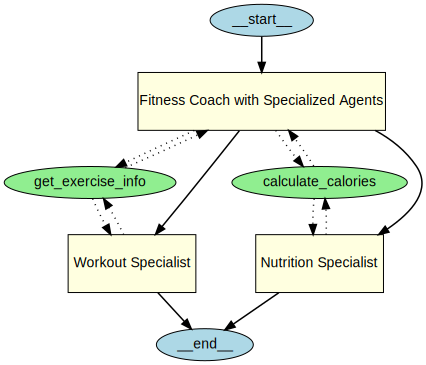

In [ ]:
from agents.extensions.visualization import draw_graph

draw_graph(fitness_agent)

##Advanced Agent with tools,handoffs and guardrails

In [ ]:
from dataclasses import dataclass
from agents import InputGuardrail, InputGuardrailTripwireTriggered, Agent, Runner, RunContextWrapper, GuardrailFunctionOutput
# --- Simple Output Models ---
@dataclass
class WorkoutPlan:
    """Workout recommendation with exercises and details"""
    exercises: List[str] = Field(description="List of recommended exercises")
    notes: str = Field(description="Additional notes or form tips")

@dataclass
class MealPlan:
    """Basic meal plan recommendation"""
    daily_calories: int = Field(description="Recommended daily calorie intake")
    meal_suggestions: List[str] = Field(description="Simple meal ideas")
    notes: str = Field(description="Dietary advice and tips")

@dataclass
class GoalAnalysis:
    """Analysis of user fitness goals"""
    is_realistic: bool = Field(description="Whether the goal is realistic and healthy")
    reasoning: str = Field(description="Explanation of the analysis")


# --- User Context ---
@dataclass
class UserContext:
    user_id: str
    fitness_level: str  # Beginner, Intermediate, Advanced
    fitness_goal: str   # Weight loss, Muscle gain, General fitness
    dietary_preference: str  # Vegan, Vegetarian, No restrictions
    available_equipment: List[str]

# --- Guardrail Agent & Function ---
goal_analysis_agent = Agent(
    name="Goal Analyzer",
    instructions="""
    You analyze fitness goals to determine if they are realistic and healthy.
    Losing more than 2 pounds per week is generally considered unsafe.
    """,
    output_type=GoalAnalysis,
    model=get_model("gemini")
)

async def fitness_goal_guardrails(ctx:RunContextWrapper,agent:Agent,input_data):
    """Check if the user's fitness goal is realistic and healthy"""
    try:
        anylysis_prompt=f"The user said: {input_data.query}.\n\nAnalyze if their fitness goal is realistic and healthy."
        result=await Runner.run(
            starting_agent=goal_analysis_agent,
            input=anylysis_prompt
        )
        final_output=result.final_output_as(GoalAnalysis)

        return GuardrailFunctionOutput(
            tripwire_triggered=not final_output.is_realistic,
            output_info=final_output
            )

    except Exception as e:
        return GuardrailFunctionOutput(
            tripwire_triggered=False,
            output_info=GoalAnalysis(is_realistic=True,reasoning=f"Error analyzing goal:{str(e)}")
        )

workout_agent=Agent[UserContext](
    name="Workout Specialist",
    instructions="""
    You are a workout specialist who creates effective exercise routines.

    Consider the user's context:
    - Fitness level (beginner, intermediate, advanced)
    - Fitness goal (weight loss, muscle gain, etc.)
    - Available equipment

    Create a workout plan appropriate for their level.
    """,
    model=get_model("gemini"),
    output_type=WorkoutPlan,
    handoff_description="Specialized agent for creating workout plans."
)

nutrition_agent = Agent(
    name="Nutrition Specialist",
    instructions="""
    You are a nutrition specialist who creates meal plans.

    Consider the user's context:
    - Fitness goal (weight loss, muscle gain, etc.)
    - Dietary preference (vegan, vegetarian, etc.)

    Create a meal plan appropriate for their goals and preferences.
    """,
    model=get_model("gemini"),
    output_type=MealPlan,
    handoff_description="Specialized agent for providing nutrition advice and meal planning."
)

# --- Main Fitness Agent with Handoffs ---
fitness_agent = Agent(
    name="Fitness Coach with Specialized Agents",
    instructions="""
    You are a fitness coach who helps users achieve their health and fitness goals.
    You can also hand off to specialized agents for more detailed help:

    - When the user asks specifically about workouts or exercises, hand off to the workout specialist
    - When the user asks specifically about nutrition, diet, or meal plans, hand off to the nutrition specialist

    Only handle general fitness questions yourself. For specialized needs, use the appropriate handoff.
    """,
    model=get_model("gemini"),
    handoffs=[workout_agent, nutrition_agent],
    input_guardrails=[
        InputGuardrail(guardrail_function=fitness_goal_guardrails)
    ]
)

async def demo():
    #Create user context
    user_context=UserContext(
        user_id="123",
        fitness_level="intermediate",
        fitness_goal="weight loss",
        dietary_preference="no restriction",
        available_equipment=["dumbbells","weights"]
    )

     # Example queries
    queries = [
        "I want to start working out to lose weight. What exercises should I do?",
        "Can you give me some general fitness tips for a beginner?",
        "I want to lose 20 pounds in 2 weeks" # This should trigger the guardrail
    ]

    # Hardcoded meal plan to avoid complexity
    meal_plan_response = MealPlan(
        daily_calories=1800,
        meal_suggestions=[
            "Breakfast: Greek yogurt with berries and a sprinkle of nuts",
            "Lunch: Grilled chicken salad with mixed greens and olive oil dressing",
            "Dinner: Baked salmon with steamed vegetables and quinoa",
            "Snack: Apple slices with a tablespoon of almond butter",
            "Snack: Carrot sticks with hummus"
        ],
        notes="Focus on whole foods and lean proteins. Drink plenty of water and limit processed foods and sugars. Aim for consistent meal times and portion control."
    )

    for query in queries:
        print("\n" + "*"*50)
        print(f"QUERY: {query}")
        print("*"*50)

        try:
            # Add a special case for nutrition query to avoid complexity
            if "how should I eat" in query.lower() or "meal plan" in query.lower() or "nutrition" in query.lower():
                print("\n[🍎 NUTRITION SPECIALIST]")
                print("RESPONSE:")
                print(meal_plan_response)
            else:
                # For other queries, use the regular agent
                result = await Runner.run(fitness_agent, query, context=user_context)

                # Identify which agent handled the request
                if isinstance(result.final_output, WorkoutPlan):
                    print("\n[👟 WORKOUT SPECIALIST]")
                elif isinstance(result.final_output, MealPlan):
                    print("\n[🍎 NUTRITION SPECIALIST]")
                else:
                    print("\n[🏋️ MAIN FITNESS COACH]")

                print("RESPONSE:")
                print(result.final_output)

        except InputGuardrailTripwireTriggered as e:
            print("\n[⚠️ GUARDRAIL TRIGGERED]")
            if hasattr(e, 'guardrail_output') and hasattr(e.guardrail_output, 'reasoning'):
                print(f"Reason: {e.guardrail_output.reasoning}")
            else:
                print("An unrealistic or unsafe fitness goal was detected.")
        except Exception as e:
            print(f"\n[❌ ERROR]: {str(e)}")

if __name__ == "__main__":
    asyncio.run(demo())


**************************************************
QUERY: I want to start working out to lose weight. What exercises should I do?
**************************************************

[🏋️ MAIN FITNESS COACH]
RESPONSE:
I can provide some general guidance, but for a detailed workout plan, I recommend consulting a workout specialist. Would you like me to hand you off to them?


**************************************************
QUERY: Can you give me some general fitness tips for a beginner?
**************************************************

[🏋️ MAIN FITNESS COACH]
RESPONSE:
*   **Start slow:** Begin with 2-3 workouts per week, lasting around 30 minutes each.
*   **Warm-up:** Always warm up before each workout with light cardio and dynamic stretching.
*   **Cool-down:** Cool down after each workout with static stretching.
*   **Stay hydrated:** Drink plenty of water throughout the day, especially before, during, and after workouts.
*   **Listen to your body:** Rest when you need to, and d

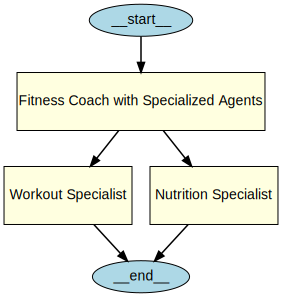

In [ ]:
draw_graph(fitness_agent)

#Memory

In [1]:
!pip install -Uq langmem langchain-google-genai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.9/62.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.0/264.0 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 10.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires 

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [12]:
from google.colab import userdata
import os
GEMINI_API_KEY=userdata.get('GEMINI_API_KEY')
os.environ["GEMINI_API_KEY"]=GEMINI_API_KEY
MODEL="google_genai:gemini-2.0-flash"

preference_conversation= [
    {"role":"user","content":"i prefer to work in office"},
    {"role":"assistant","content":"i prefer to work in office"},
]

In [9]:
pip install -U langchain-google-vertexai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0


In [14]:
from langmem import create_memory_manager

# Use the model name that langchain-google-vertexai recognizes
# create_memory_manager will handle the initialization based on the model name
manager = create_memory_manager(MODEL) # Using a model name recognized by ChatVertexAI

# extract memories from conversation
memories= await manager.ainvoke({"messages": preference_conversation})

print(memories)

ERROR:grpc._plugin_wrapping:AuthMetadataPluginCallback "<google.auth.transport.grpc.AuthMetadataPlugin object at 0x7f6e73768fd0>" raised exception!
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/google/auth/compute_engine/credentials.py", line 126, in refresh
    self._retrieve_info(request)
  File "/usr/local/lib/python3.11/dist-packages/google/auth/compute_engine/credentials.py", line 99, in _retrieve_info
    info = _metadata.get_service_account_info(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/google/auth/compute_engine/_metadata.py", line 338, in get_service_account_info
    return get(request, path, params={"recursive": "true"})
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/google/auth/compute_engine/_metadata.py", line 263, in get
    raise exceptions.TransportError(
google.auth.exceptions.TransportError: ("Failed to retrieve http:/

CancelledError: 

In [15]:

from pydantic import BaseModel
from langmem import create_memory_manager

class PreferenceMemory(BaseModel):
    """Store the user's preference"""
    category: str
    preference: str
    context: str

manager = create_memory_manager(
    MODEL,
    schemas=[PreferenceMemory]
)


memories = await manager.ainvoke({"messages": preference_conversation})
print("\n[MEM]", memories, "\n")
print(memories[0][1])
# Output:
# PreferenceMemory(
#     category="ui",
#     preference="dark_mode",
#     context="User explicitly stated preference for dark mode in all applications"

ERROR:grpc._plugin_wrapping:AuthMetadataPluginCallback "<google.auth.transport.grpc.AuthMetadataPlugin object at 0x7f6e737c8190>" raised exception!
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/google/auth/compute_engine/credentials.py", line 126, in refresh
    self._retrieve_info(request)
  File "/usr/local/lib/python3.11/dist-packages/google/auth/compute_engine/credentials.py", line 99, in _retrieve_info
    info = _metadata.get_service_account_info(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/google/auth/compute_engine/_metadata.py", line 338, in get_service_account_info
    return get(request, path, params={"recursive": "true"})
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/google/auth/compute_engine/_metadata.py", line 263, in get
    raise exceptions.TransportError(
google.auth.exceptions.TransportError: ("Failed to retrieve http:/

CancelledError: 